In [7]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
import scipy.optimize as spo
import scipy.special as sps
import math
from matplotlib.gridspec import GridSpec

## A product from GonzNuevoClust. Should be upto date with the latest tested version of GonzNuevoClust.ipynb

In [8]:
def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)

def plaw_pspec_to_2pcf(const, delta):
    alpha = 3 - delta
    A = const * (sps.gamma(alpha/2))/ (np.power(2, 3/2 - alpha) * sps.gamma((3 - alpha)/2)) ## Change alert
    return A, alpha

def plaw_2pcf_to_pspec(A, alpha):
    delta = 3 - alpha
    const = A * (np.power(2, 3/2 - alpha) * sps.gamma((3 - alpha)/2)) / (sps.gamma(alpha/2))
    return const, delta

class clust_dist:
    def __init__(self, N_side, dx) -> None:
        self.N_side = N_side
        self.dx = dx
        #dk of the fourier lattice.
        self.dk = 2 * np.pi/(self.N_side * self.dx)

    def initialize_pois(self, n_bar):
        self.n_bar = n_bar
        
        #Creating a box with N_side^3 dimension and fill it with poisson random numbers with lambda=n_bar.
        self.box_p = np.random.poisson(lam=n_bar, size=(self.N_side, self.N_side, self.N_side))
        print("Poisson lattice is created.")
        #Density contrast.
        self.box_delx = (self.box_p - n_bar)/n_bar
        #Now taking the fourier transform of box_delx to get box_delk
        self.box_delk = np.fft.fftn(self.box_delx, norm='ortho')
        temp_factor = np.power(self.dx * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delk = temp_factor * self.box_delk
        #Getting the corresponding k values along 1d axis and creating a 3d grid of corresponding k value
        #of the box_delk.
        temp_k_vals = 2 * np.pi * np.fft.fftfreq(self.N_side, d=self.dx)
        self.temp_k_vals = temp_k_vals
        self.temp_k_vals =temp_k_vals
        temb_mesh = np.meshgrid(temp_k_vals, temp_k_vals, temp_k_vals, indexing='ij')
        self.modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)
        #Finding the minimum and maximum of k values
        self.k_min = 0
        self.k_max = 2 * np.pi/(2 * self.dx)* np.sqrt(3)
        #Finding the powerspectrum here.
        self.k_intervals = np.linspace(self.k_min, self.k_max, self.N_side//2) #default k_intervals
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)
        print("Poisson power spectrum calculated.")

    def initialize_gauss(self, lam, sig):
        self.n_bar = lam

        #Creating a box with N_side^3 dimension and fill it with Gaussian random numbers with lambda=lam and sigma = sig.
        self.box_p = np.random.normal(loc=lam, scale=sig, size=(self.N_side, self.N_side, self.N_side))
        print("Gaussian lattice is created.")
        #Density contrast.
        self.box_delx = (self.box_p - lam)/lam
        #Now taking the fourier transform of box_delx to get box_delk
        self.box_delk = np.fft.fftn(self.box_delx, norm='ortho')
        temp_factor = np.power(self.dx * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delk = temp_factor * self.box_delk
        #Getting the corresponding k values along 1d axis and creating a 3d grid of corresponding k value
        #of the box_delk.
        temp_k_vals = 2 * np.pi * np.fft.fftfreq(self.N_side, d=self.dx)
        self.temp_k_vals =temp_k_vals
        temb_mesh = np.meshgrid(temp_k_vals, temp_k_vals, temp_k_vals, indexing='ij')
        self.modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)
        #Finding the minimum and maximum of k values
        self.k_min = 0
        self.k_max = 2 * np.pi/(2 * self.dx)* np.sqrt(3)
        #Finding the powerspectrum here.
        self.k_intervals = np.linspace(self.k_min, self.k_max, self.N_side//2) #default k_intervals
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)
        print("Poisson power spectrum calculated.")
    
    def calc_powerspec_pois(self, k_intervals):
        #Finding the powerspectrum here. Iterate through the k_for_P and find the index of modk_grid with k
        #that falls between and find power spectrum pk.
        powerspec = np.zeros(len(k_intervals)-1)
        for i, (k1, k2) in enumerate(zip(k_intervals[:-1], k_intervals[1:])):
            powerspec[i] = np.average(np.absolute(self.box_delk[np.where((self.modk_grid >= k1) & (self.modk_grid < k2))]) ** 2)
        powerspec = powerspec/((self.N_side * self.dx)**3) * np.power(np.sqrt(2 * np.pi), 3)

        return powerspec
    
    def calc_powerspec_clust(self, k_intervals):
        powerspec = np.zeros(len(k_intervals)-1)
        for i, (k1, k2) in enumerate(zip(k_intervals[:-1], k_intervals[1:])):
            powerspec[i] = np.average(np.absolute(self.box_delk_clust[np.where((self.modk_grid >= k1) & (self.modk_grid < k2))]) ** 2)
        powerspec = powerspec/((self.N_side * self.dx)**3) * np.power(np.sqrt(2 * np.pi), 3)

        return powerspec
    
    def update_k_intervals(self, k_intervals):
        ##Assert that the given k_intervals have appropriate k_min and k_max
        assert k_intervals[0] == self.k_min
        # assert k_intervals[-1] == self.k_max
        #updating the k_intervals
        self.k_intervals = np.copy(k_intervals)
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)

    def make_clust_dist(self, powerspec_clust, k_intervals):
        #Making the new box_delk_clust. Right now, whenever we call this method, the previous box_delk_clust if any
        #will be erased.
        self.box_delk_clust = np.copy(self.box_delk)
        #Modifying the box-delk_clust to have the input powerspectrum.
        for i, (k1, k2) in enumerate(zip(k_intervals[:-1], k_intervals[1:])):
            temp_ind = np.where((self.modk_grid > k1) & (self.modk_grid < k2))
            self.box_delk_clust[temp_ind] = self.box_delk[temp_ind] * (np.sqrt(powerspec_clust[i] + self.powerspec_pois[i])) / np.sqrt(self.powerspec_pois[i])
        #Defining the input powerspec as the powerspec of box_delk_clust
        
        self.powerspec_clust = np.copy(powerspec_clust)
        self.update_k_intervals(k_intervals)
        #Now we need to inverse fourier transfor box_delk_clust to get box_delx_clust
        self.box_delx_clust = np.fft.ifftn(self.box_delk_clust, norm='ortho')
        temp_factor = np.power(self.dk * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delx_clust = temp_factor * self.box_delx_clust
        #Create the new n(x) array.
        self.box_GN = self.n_bar * (1 + self.box_delx_clust)
        print("Made the clustered distribution.")

    def make_clust_dist_from_plaw_pspec(self, const, delta, k_intervals):
        self.const_of_pk = const
        self.delta_of_pk = delta
        if not np.array_equal(k_intervals, self.k_intervals):
            self.update_k_intervals(k_intervals)
        temp_pk = const * np.power(self.k_intervals_mid, -delta)
        self.make_clust_dist(temp_pk, self.k_intervals) 

    def calc_2pcorrfunc_clust(self, x_min, x_max):
        assert x_min > 0
        assert x_max > x_min
        # assert issubclass(x_intervals_int.dtype.int, np.integer)
        # min and max integer between given interval
        x_min_int = math.ceil(x_min/self.dx)
        x_max_int = math.ceil(x_max/self.dx)
        #defining the x intervals in which we calculate the 2pcf
        self.x_intervals_pix = np.arange(x_min_int, x_max_int)
        self.x_intervals_mid = self.x_intervals_pix * self.dx #I chose only even
        self._2pcorrfunc = np.zeros_like(self.x_intervals_mid)
        for i, temp_x in enumerate(self.x_intervals_pix):
            self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
        print("2 point correlation function calculated.")

    def calc_2pcorrfunc_clust_ax2(self, x_min, x_max):
        assert x_min > 0
        assert x_max > x_min
        # assert issubclass(x_intervals_int.dtype.int, np.integer)
        # min and max integer between given interval
        x_min_int = math.ceil(x_min/self.dx)
        x_max_int = math.ceil(x_max/self.dx)
        #defining the x intervals in which we calculate the 2pcf
        self.x_intervals_pix = np.arange(x_min_int, x_max_int)
        self.x_intervals_mid = self.x_intervals_pix * self.dx #I chose only even
        self._2pcorrfunc = np.zeros_like(self.x_intervals_mid)
        for i, temp_x in enumerate(self.x_intervals_pix):
            self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:,:self.N_side-temp_x,:]) * (self.box_delx_clust[:,temp_x:,:]))/ (self.N_side** 3)
        print("2 point correlation function calculated.")

    def calc_2pcorrfunc_clust_ax3(self, x_min, x_max):
        assert x_min > 0
        assert x_max > x_min
        # assert issubclass(x_intervals_int.dtype.int, np.integer)
        # min and max integer between given interval
        x_min_int = math.ceil(x_min/self.dx)
        x_max_int = math.ceil(x_max/self.dx)
        #defining the x intervals in which we calculate the 2pcf
        self.x_intervals_pix = np.arange(x_min_int, x_max_int)
        self.x_intervals_mid = self.x_intervals_pix * self.dx #I chose only even
        self._2pcorrfunc = np.zeros_like(self.x_intervals_mid)
        for i, temp_x in enumerate(self.x_intervals_pix):
            self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:,:,:self.N_side-temp_x]) * (self.box_delx_clust[:,:,temp_x:]))/ (self.N_side** 3)
        print("2 point correlation function calculated.")        

    def calc_2pcorrfunc_clust2(self, x_min, x_max):
        assert x_min > 0
        assert x_max > x_min
        # assert issubclass(x_intervals_int.dtype.int, np.integer)
        # min and max integer between given interval
        x_min_int = math.ceil(x_min/self.dx)
        x_max_int = math.ceil(x_max/self.dx)

        box_r = np.random.poisson(lam=self.n_bar, size=(self.N_side, self.N_side, self.N_side))
        bins = np.arange(x_min_int, x_max_int)
        self.x_intervals_mid = (bins[:-1] + bins[1:])/2 * self.dx
        x1, y1, z1 = np.asarray(np.meshgrid(np.arange(self.N_side), np.arange(self.N_side), np.arange(self.N_side), indexing='xy'), dtype='float')
        x1 = x1.flatten()
        y1 = y1.flatten()
        z1 = z1.flatten()
        weights1 = np.asarray(self.box_GN.flatten(), dtype='float')

        result_DD_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, weight_type='pair_product', periodic=False, output_ravg=True)

        weights2 = np.asarray(box_r.flatten(), dtype='float')
        x_r, y_r, z_r = np.asarray(np.meshgrid(np.arange(self.N_side), np.arange(self.N_side), np.arange(self.N_side), indexing='xy'), dtype='float')
        x_r = x_r.flatten()
        y_r = y_r.flatten()
        z_r = z_r.flatten()
        result_RR_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x_r, Y1 = y_r, Z1 = z_r, weights1 = weights2, weight_type='pair_product', periodic=False, output_ravg=True)

        result_DR_GN = DD(autocorr=0, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, X2 = x_r, Y2 = y_r, Z2 = z_r, weights2 = weights2, \
               weight_type='pair_product', periodic=False, output_ravg=True)
        #Now with DD, RR and DR that we obtained, we will find the xi(r), two point correlation function.
        #We need normalisation also, which is the total number of pairs.
        DD_count_GN = (result_DD_GN['npairs']*result_DD_GN['weightavg'])/2
        DR_count_GN = result_DR_GN['npairs']*result_DR_GN['weightavg']
        RR_count_GN = (result_RR_GN['npairs']*result_RR_GN['weightavg'])/2
        DD_total_GN = (np.sum(weights1) * (np.sum(weights1) - 1))/2
        RR_total_GN = (np.sum(weights2) * (np.sum(weights2) - 1))/2
        DR_total_GN = (np.sum(weights1) * np.sum(weights2))

        self._2pcorrfunc = (DD_count_GN/DD_total_GN - 2 * DR_count_GN/DR_total_GN + RR_count_GN/RR_total_GN)/(RR_count_GN/RR_total_GN)


    def fit_2pcf_clust(self):
        temp_popt, temp_pcov = spo.curve_fit(pow_func, self.x_intervals_mid, self._2pcorrfunc)
        self._2pcf_fit_alpha = temp_popt[1]
        self._2pcf_fit_A = temp_popt[0]
        print("The measured 2pcf of box_delx_clust is fitted to a power law")

    def show_delx_dist(self):
        fig, ax = plt.subplots()
        ax.hist((self.box_delx_clust).flatten(), bins=100)
        ax.hist((self.box_delx).flatten(), bins=100)
        return fig, ax
    
    def show_powerspecs(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
        ax1.plot(self.k_intervals_mid, self.powerspec_pois, '-*', label="Measured")
        ax1.set_ylabel(r'$P(K)$')
        ax1.set_xlabel(r'$k$')
        ax1.set_title('power spectrum of poisson lattice')
        ax1.axhline((1/self.n_bar) * (self.dx / np.sqrt(2 * np.pi))**3, color ='k', label="expected")

        ax2.plot(self.k_intervals_mid, self.calc_powerspec_clust(self.k_intervals), '-*', label="measured")
        ax2.plot(self.k_intervals_mid, self.const_of_pk*np.power(self.k_intervals_mid, -self.delta_of_pk), '-*', label="input")
        # ax2.plot(self.k_intervals_mid, self.powerspec_clust, '-*', label="input")
        ax2.set_ylabel(r'$P(K)$')
        ax2.set_xlabel(r'$k$')
        ax2.set_title('power spectrum of clustered lattice')
        ax1.legend()
        ax2.legend()
        ax2.set_yscale('log')
        ax2.set_xscale('log')
        return fig, (ax1, ax2)    
    
    

In [9]:
class incomp_dist(clust_dist):
    def initiate_incomp_eff(self):
        self.incomp_map = np.ones_like(self.box_GN)
        self.incomp_box_GN = np.copy(self.box_GN)
        print("Incompleteness effect initiated")

    def apply_incomp_map(self):
        self.incomp_box_GN = self.incomp_box_GN * self.incomp_map
        self.incomp_box_delx_clust = (self.incomp_box_GN - self.n_bar)/self.n_bar
        print("Incompleteness map applied")

    def calc_2pcorrfunc_incomp(self):
        #We use the same x intervals as the clust 2pcf
        self._2pcorrfunc_incomp = np.zeros_like(self.x_intervals_mid)
        for i, temp_x in enumerate(self.x_intervals_pix):
            self._2pcorrfunc_incomp[i] = np.sum((self.incomp_box_delx_clust[:self.N_side-temp_x,:,:]) * (self.incomp_box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
            self._2pcorrfunc_incomp[i] = self._2pcorrfunc_incomp[i]/(np.sum(self.incomp_map[:self.N_side-temp_x,:,:] * self.incomp_map[temp_x:,:,:])/ (self.N_side**3))
        print("2 point correlation function of incomplete dist calculated.")

    def fit_2pcf_clust_incomp(self):
        temp_popt, temp_pcov = spo.curve_fit(pow_func, self.x_intervals_mid, self._2pcorrfunc_incomp)
        self._2pcf_fit_alpha_incomp = temp_popt[1]
        self._2pcf_fit_A_incomp = temp_popt[0]
        print("The measured 2pcf of box_delx_clust is fitted to a power law")

## Begins here

/tmp/ipykernel_1721698/161632270.py:139: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
/tmp/ipykernel_1721698/1679162206.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc_incomp[i] = np.sum((self.incomp_box_delx_clust[:self.N_side-temp_x,:,:]) * (self.incomp_box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
/tmp/ipykernel_1721698/1679162206.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc_incomp[i] = self._2pcorrfunc_incomp[i]/(np.sum(self.incomp_map[:self.N_side-temp_x,:,:] * self.incomp_map[temp_x:,:,:])/ (self.N_side**3))


Text(0.5, 0.98, 'Input power spectrum and resulting 2pcf')

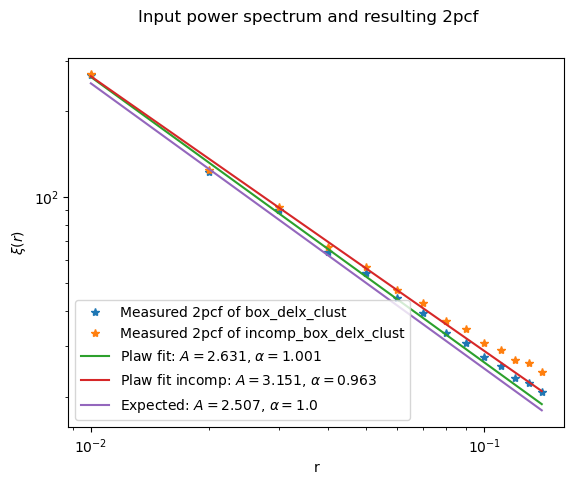

In [13]:
N_side = 256
dx = 0.01
n_bar = 50
const_of_pk = 2.0
delta_of_pk = 2.0

sample_clust = incomp_dist(N_side, dx)
sample_clust.initialize_pois(n_bar)

sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals)

sample_clust.calc_2pcorrfunc_clust(1 * dx, 15 * dx)

sample_clust.fit_2pcf_clust()

exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

sample_clust.initiate_incomp_eff()
sample_clust.incomp_map[-100:,:,:] = 0
sample_clust.apply_incomp_map()
sample_clust.calc_2pcorrfunc_incomp()
sample_clust.fit_2pcf_clust_incomp()

fig, ax = plt.subplots()

ax.plot(sample_clust.x_intervals_mid, sample_clust._2pcorrfunc, '*', label="Measured 2pcf of box_delx_clust")
ax.plot(sample_clust.x_intervals_mid, sample_clust._2pcorrfunc_incomp, '*', label="Measured 2pcf of incomp_box_delx_clust")
ax.plot(sample_clust.x_intervals_mid, sample_clust._2pcf_fit_A * np.power(sample_clust.x_intervals_mid, -sample_clust._2pcf_fit_alpha), \
                label=r"Plaw fit: $A = {}$, $\alpha = {}$".format(np.round(sample_clust._2pcf_fit_A,3), np.round(sample_clust._2pcf_fit_alpha,3)))
ax.plot(sample_clust.x_intervals_mid, sample_clust._2pcf_fit_A_incomp * np.power(sample_clust.x_intervals_mid, -sample_clust._2pcf_fit_alpha_incomp), \
                label=r"Plaw fit incomp: $A = {}$, $\alpha = {}$".format(np.round(sample_clust._2pcf_fit_A_incomp,3), np.round(sample_clust._2pcf_fit_alpha_incomp,3)))
ax.plot(sample_clust.x_intervals_mid, exp_A * np.power(sample_clust.x_intervals_mid, -exp_alpha), \
            label=r"Expected: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('r')
ax.set_ylabel(r'$\xi(r)$')
fig.suptitle("Input power spectrum and resulting 2pcf")

### 2pcf along different axis-comparison

In [6]:
N_side = 256
dx = 0.01
n_bar = 50
const_of_pk = 2.0
delta_of_pk = 1.0

orig_2pcf_ax1 = np.zeros((100,14))
orig_2pcf_ax2 = np.zeros((100,14))
orig_2pcf_ax3 = np.zeros((100,14))
for i in range(100):
    blockPrint()
    sample_clust = incomp_dist(N_side, dx)
    sample_clust.initialize_pois(n_bar)

    sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals)

    sample_clust.calc_2pcorrfunc_clust(1 * dx, 15 * dx)

    orig_2pcf_ax1[i] = sample_clust._2pcorrfunc

    # sample_clust.fit_2pcf_clust()

    # exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)
    sample_clust.calc_2pcorrfunc_clust_ax2(1 * dx, 15 * dx)    
    
    orig_2pcf_ax2[i] = sample_clust._2pcorrfunc

    sample_clust.calc_2pcorrfunc_clust_ax3(1 * dx, 15 * dx)    
    
    orig_2pcf_ax3[i] = sample_clust._2pcorrfunc

# sample_clust.fit_2pcf_clust_incomp()
sys.stdout = open("tempoutput.txt",'w')
print("orig_2pcf_ax1 mean =", np.mean(orig_2pcf_ax1, axis=0))
print("orig_2pcf ax1 var = ", np.var(orig_2pcf_ax1, axis=0))
print("orig_2pcf_ax2 mean = ", np.mean(orig_2pcf_ax2, axis=0))
print("orig_2pcf_ax2 var = ", np.var(orig_2pcf_ax2, axis=0))
print("orig_2pcf_ax3 mean = ", np.mean(orig_2pcf_ax3, axis=0))
print("orig_2pcf_ax3 var = ", np.var(orig_2pcf_ax3, axis=0))

/tmp/ipykernel_1828262/3652077428.py:139: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
/tmp/ipykernel_1828262/3652077428.py:154: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:,:self.N_side-temp_x,:]) * (self.box_delx_clust[:,temp_x:,:]))/ (self.N_side** 3)
/tmp/ipykernel_1828262/3652077428.py:169: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:,:,:self.N_side-temp_x]) * (self.box_delx_clust[:,:,temp_x:]))/ (self.N_side** 3)


## Characteristics of incompleteness

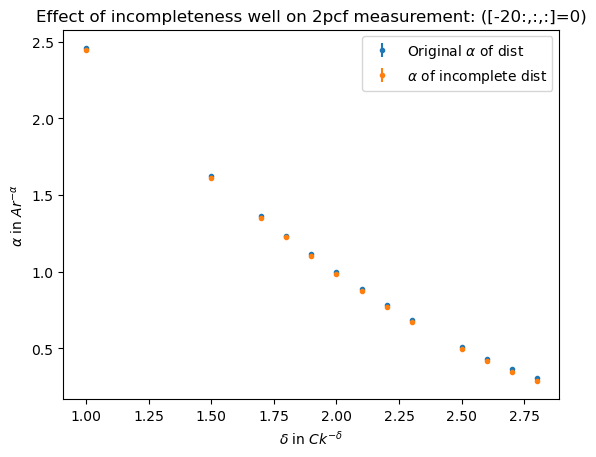

In [10]:
Original_A = np.array([0.235, 1.246, 1.76, 2.055, 2.319, 2.645, 2.969, 3.375, 3.562, 3.936, 4.21, 4.414, 4.362])
Original_alpha = np.array([2.457, 1.624, 1.361, 1.235, 1.118, 0.999, 0.887, 0.774, 0.682, 0.511, 0.428, 0.355, 0.302])

Original_A_mean = np.array([0.2346, 1.2367, 1.7638, 2.0492, 2.3344, 2.6332, 2.9397, 3.2402, 3.5156, 3.9818, 4.1568, 4.2645, 4.2865])
Original_A_var = np.array([0.0002, 0.0008, 0.0014, 0.0013, 0.0024, 0.0028, 0.0025, 0.0032, 0.0045, 0.0078, 0.0073, 0.0090, 0.0115])
Original_alpha_mean = np.array([2.45702, 1.62565, 1.36079, 1.23564, 1.11614, 1.00052, 0.88937, 0.78380, 0.68504, 0.50841, 0.43138, 0.36347, 0.30538])
Original_alpha_var = np.array([0.00017, 0.00003, 0.00002, 0.00001, 0.00002, 0.00002, 0.00001, 0.00002, 0.00002, 0.00003, 0.00002, 0.00003, 0.00003])

Incomp_A = np.array([0.244, 1.26, 1.882, 2.164, 2.533, 2.836, 3.33, 3.705, 4.025, 4.311, 4.497, 5.09, 4.953])
Incomp_alpha = np.array([2.449, 1.622, 1.348, 1.225, 1.099, 0.985, 0.864, 0.755, 0.657, 0.491, 0.415, 0.329, 0.278])

Incomp_A_mean = np.array([0.24652, 1.30924, 1.86511, 2.16847, 2.49071, 2.81984, 3.13248, 3.47318, 3.78548, 4.29239, 4.46738, 4.63850, 4.63205])
Incomp_A_var = np.array([0.00031, 0.00183, 0.00416, 0.00429, 0.00919, 0.00985, 0.02237, 0.02726, 0.03378, 0.06103, 0.05823, 0.07472, 0.07546])
Incomp_alpha_mean = np.array([2.44725, 1.61415, 1.34949, 1.22417, 1.10286, 0.98638, 0.87639, 0.76950, 0.66975, 0.49274, 0.41646, 0.34646, 0.28956])
Incomp_alpha_var = np.array([0.00024, 0.00005, 0.00006, 0.00004, 0.00007, 0.00006, 0.00011, 0.00010, 0.00010, 0.00013, 0.00012, 0.00013, 0.00012])

temp_delta = [1.0, 1.5, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5, 2.6, 2.7, 2.8]

# plt.plot(temp_delta, Original_alpha, label="Original alpha of dist")
plt.errorbar(temp_delta, Original_alpha_mean, yerr=np.sqrt(Original_alpha_var), fmt='.', label=r"Original $\alpha$ of dist")
plt.errorbar(temp_delta, Incomp_alpha_mean, yerr=np.sqrt(Incomp_alpha_var), fmt='.', label=r"$\alpha$ of incomplete dist")
# plt.plot(temp_delta, Incomp_alpha, ".", label=r"$\alpha$ of incomplete dist")
plt.ylabel(r"$\alpha$ in $Ar^{-\alpha}$")
plt.xlabel(r"$\delta$ in $Ck^{-\delta}$")
plt.title("Effect of incompleteness well on 2pcf measurement: ([-20:,:,:]=0)")
plt.legend()


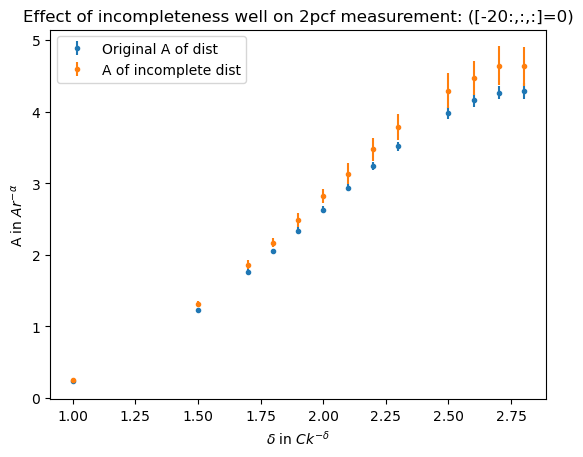

In [15]:
# plt.plot(temp_delta, Original_A, label="Original A of dist")
plt.errorbar(temp_delta, Original_A_mean, yerr=np.sqrt(Original_A_var), fmt='.', label="Original A of dist")
plt.errorbar(temp_delta, Incomp_A_mean, yerr=np.sqrt(Incomp_A_var), fmt='.', label="A of incomplete dist")
# plt.plot(temp_delta, Incomp_A, ".", label="A of incomplete dist")
plt.ylabel(r"A in $Ar^{-\alpha}$")
plt.xlabel(r"$\delta$ in $Ck^{-\delta}$")
plt.title("Effect of incompleteness well on 2pcf measurement: ([-20:,:,:]=0)")
plt.legend()

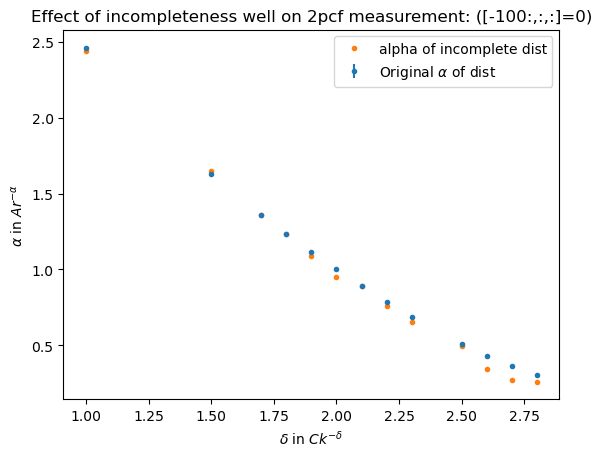

In [72]:
Original_A2 = np.array([0.241, 1.248, 1.677, 2.081, 2.399, 2.609, 3.017, 3.211, 3.523, 3.907, 4.239, 4.444, 4.244])
Original_alpha2 = np.array([2.451, 1.624, 1.372, 1.232, 1.11, 1.003, 0.884, 0.786, 0.684, 0.513, 0.427, 0.354, 0.308])
Incomp_A2 = np.array([0.258, 1.111, 1.793, 2.068, 2.662, 3.334, 2.908, 3.617, 4.155, 4.221, 6.626, 7.371, 5.754])
Incomp_alpha2 = np.array([2.437, 1.649, 1.358, 1.234, 1.088, 0.952, 0.891, 0.762, 0.651, 0.496, 0.347, 0.27, 0.256])
temp_delta2 = [1.0, 1.5, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5, 2.6, 2.7, 2.8]

# plt.plot(temp_delta2, Original_alpha2, label="Original alpha of dist")
plt.errorbar(temp_delta, Original_alpha_mean, yerr=np.sqrt(Original_alpha_var), fmt='.', label=r"Original $\alpha$ of dist")
plt.plot(temp_delta2, Incomp_alpha2, ".", label="alpha of incomplete dist")
plt.ylabel(r"$\alpha$ in $Ar^{-\alpha}$")
plt.xlabel(r"$\delta$ in $Ck^{-\delta}$")
plt.title("Effect of incompleteness well on 2pcf measurement: ([-100:,:,:]=0)")
plt.legend()

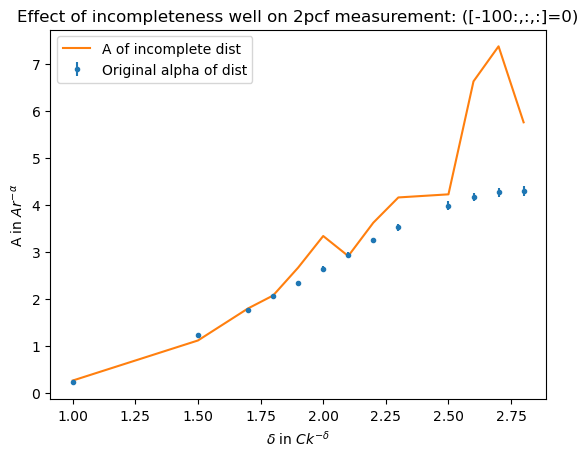

In [77]:
# plt.plot(temp_delta2, Original_A2, label="Original A of dist")
plt.errorbar(temp_delta, Original_A_mean, yerr=np.sqrt(Original_A_var), fmt='.', label="Original alpha of dist")
plt.plot(temp_delta2, Incomp_A2, label="A of incomplete dist")
plt.ylabel(r"A in $Ar^{-\alpha}$")
plt.xlabel(r"$\delta$ in $Ck^{-\delta}$")
plt.title("Effect of incompleteness well on 2pcf measurement: ([-100:,:,:]=0)")
plt.legend()

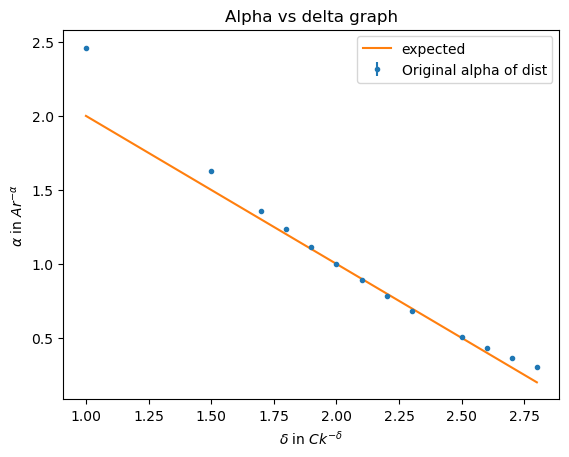

In [58]:
Original_A_mean = np.array([0.2346, 1.2367, 1.7638, 2.0492, 2.3344, 2.6332, 2.9397, 3.2402, 3.5156, 3.9818, 4.1568, 4.2645, 4.2865])
Original_A_var = np.array([0.0002, 0.0008, 0.0014, 0.0013, 0.0024, 0.0028, 0.0025, 0.0032, 0.0045, 0.0078, 0.0073, 0.0090, 0.0115])
Original_alpha_mean = np.array([2.45702, 1.62565, 1.36079, 1.23564, 1.11614, 1.00052, 0.88937, 0.78380, 0.68504, 0.50841, 0.43138, 0.36347, 0.30538])
Original_alpha_var = np.array([0.00017, 0.00003, 0.00002, 0.00001, 0.00002, 0.00002, 0.00001, 0.00002, 0.00002, 0.00003, 0.00002, 0.00003, 0.00003])
temp_delta = np.array([1.0, 1.5, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5, 2.6, 2.7, 2.8])

plt.errorbar(temp_delta, Original_alpha_mean, yerr=np.sqrt(Original_alpha_var), fmt='.', label="Original alpha of dist")
plt.plot(temp_delta, 3-temp_delta, label="expected")
plt.ylabel(r"$\alpha$ in $Ar^{-\alpha}$")
plt.xlabel(r"$\delta$ in $Ck^{-\delta}$")
plt.title("Alpha vs delta graph")
plt.legend()

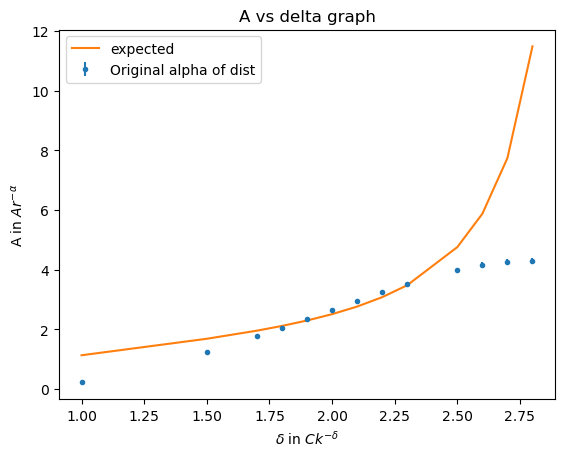

In [61]:
exp_A, temp_nil = np.vectorize(plaw_pspec_to_2pcf)(np.ones_like(temp_delta)*2, temp_delta)

plt.errorbar(temp_delta, Original_A_mean, yerr=np.sqrt(Original_A_var), fmt='.', label="Original alpha of dist")
plt.plot(temp_delta, exp_A, label="expected")
plt.ylabel(r"A in $Ar^{-\alpha}$")
plt.xlabel(r"$\delta$ in $Ck^{-\delta}$")
plt.title("A vs delta graph")
plt.legend()

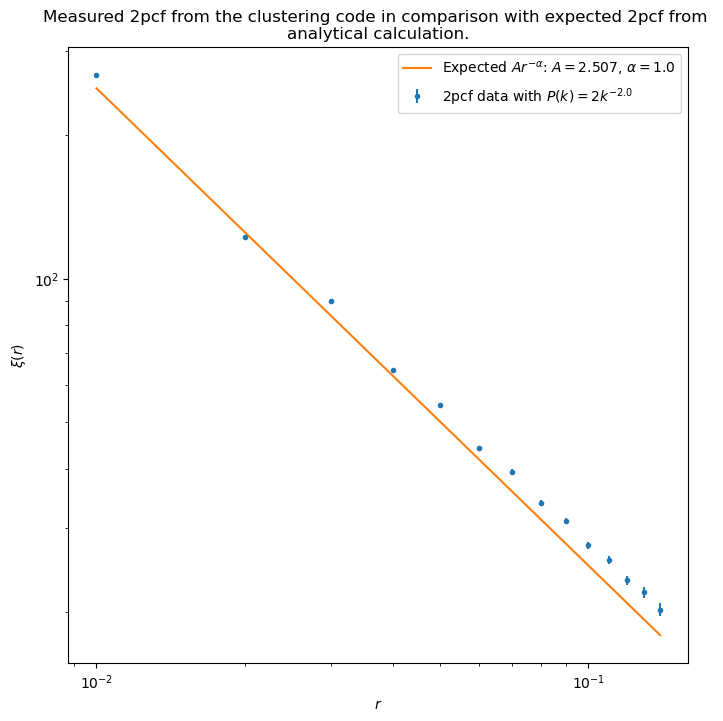

In [32]:
## delta = 1.0. Incompleteness effect with [-20:,:,:]=0
Original_2pcf_mean = np.array([267.01378648, 122.25599269, 89.83415023, 64.24332052, 54.39423392, 44.12286025, 39.43009151, 33.89528907, 31.09097264, 27.61251634, 25.71869002, 23.31586015, 21.99750278, 20.26013347])
Original_2pcf_var = np.array([0.00887, 0.02823136, 0.040554, 0.06381713, 0.08136011, 0.10426538, 0.15255197, 0.1730792, 0.18973484, 0.20600921, 0.25541116, 0.282736, 0.32712179, 0.36471593])
Incomp_2pcf_mean = np.array([268.14063334, 123.29418011, 90.96890894, 65.33669508, 55.55408093, 45.25559564, 40.61104406, 35.05134149, 32.27826719, 28.78409023, 26.9256872, 24.51233528, 23.22350373, 21.46925998])
Incomp_2pcf_var = np.array([0.31058589, 0.37729513, 0.42344606, 0.4698148, 0.48507255, 0.51064727, 0.5802888, 0.6029911, 0.64538029, 0.65969415, 0.71871708, 0.76772762, 0.82686906, 0.91752289])
x_intervals_mid = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14])

exp_A, exp_alpha = plaw_pspec_to_2pcf(2.0, 2.0)

fig, ax1 = plt.subplots( figsize=(8,8))
ax1.errorbar(x_intervals_mid, Original_2pcf_mean, yerr=np.sqrt(Original_2pcf_var), fmt='.', label = r"2pcf data with $P(k) = 2k^{-2.0}$")
ax1.plot(x_intervals_mid, exp_A * np.power(x_intervals_mid, -exp_alpha), \
            label=r"Expected $Ar^{{-\alpha}}$: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
# ax1.errorbar(x_intervals_mid, Incomp_2pcf_mean, yerr=np.sqrt(Incomp_2pcf_var), fmt='.', label="2pcf with incompleteness applied")
ax1.set_ylabel(r"$\xi(r)$")
ax1.set_xlabel(r"$r$")
ax1.legend()

ax1.set_title("Measured 2pcf from the clustering code in comparison with expected 2pcf from \nanalytical calculation.")
ax1.set_xscale('log')
ax1.set_yscale('log')

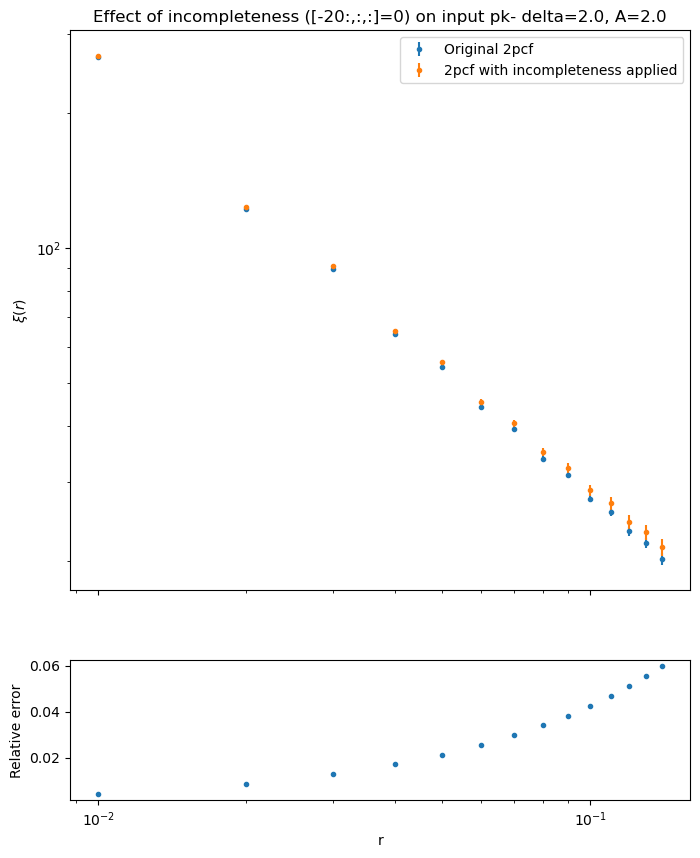

In [25]:
## delta = 2.0. Incompleteness effect with [-20:,:,:]=0
Original_2pcf_mean = np.array([267.01378648, 122.25599269, 89.83415023, 64.24332052, 54.39423392, 44.12286025, 39.43009151, 33.89528907, 31.09097264, 27.61251634, 25.71869002, 23.31586015, 21.99750278, 20.26013347])
Original_2pcf_var = np.array([0.00887, 0.02823136, 0.040554, 0.06381713, 0.08136011, 0.10426538, 0.15255197, 0.1730792, 0.18973484, 0.20600921, 0.25541116, 0.282736, 0.32712179, 0.36471593])
Incomp_2pcf_mean = np.array([268.14063334, 123.29418011, 90.96890894, 65.33669508, 55.55408093, 45.25559564, 40.61104406, 35.05134149, 32.27826719, 28.78409023, 26.9256872, 24.51233528, 23.22350373, 21.46925998])
Incomp_2pcf_var = np.array([0.31058589, 0.37729513, 0.42344606, 0.4698148, 0.48507255, 0.51064727, 0.5802888, 0.6029911, 0.64538029, 0.65969415, 0.71871708, 0.76772762, 0.82686906, 0.91752289])
x_intervals_mid = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10), height_ratios=[8,2], sharex=True)
ax1.errorbar(x_intervals_mid, Original_2pcf_mean, yerr=np.sqrt(Original_2pcf_var), fmt='.', label = "Original 2pcf")
ax1.errorbar(x_intervals_mid, Incomp_2pcf_mean, yerr=np.sqrt(Incomp_2pcf_var), fmt='.', label="2pcf with incompleteness applied")
ax1.set_ylabel(r"$\xi(r)$")
ax1.legend()
ax2.plot(x_intervals_mid, (Incomp_2pcf_mean-Original_2pcf_mean)/Original_2pcf_mean, '.')
ax2.set_ylabel("Relative error")
ax2.set_xlabel("r")
ax1.set_title("Effect of incompleteness ([-20:,:,:]=0) on input pk- delta=2.0, A=2.0")
ax1.set_xscale('log')
ax1.set_yscale('log')

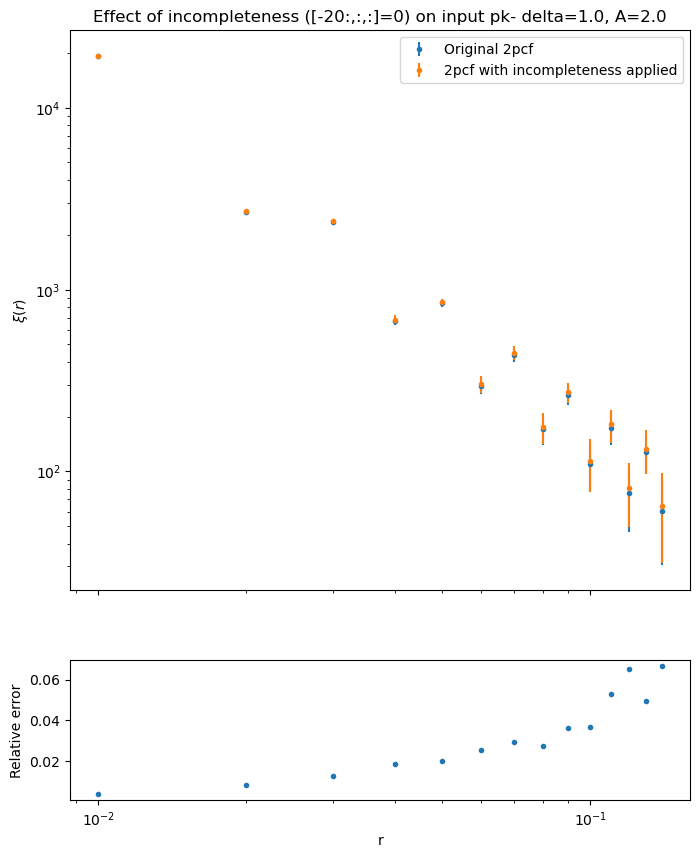

In [26]:
## delta = 1.0. Incompleteness effect with [-20:,:,:]=0
Original_2pcf_mean = np.array([19275.65509426, 2682.57019946, 2339.21648241, 670.63934879, 839.59078253, 294.41067744, 436.4711501, 170.09603097, 262.27603522, 110.29773406, 172.03674921, 75.57283744, 126.92848387, 60.42835967])
Original_2pcf_var = np.array([512.18764573, 870.33482541, 852.89763052, 1168.61084025, 1106.56397142, 828.33716395, 1318.18900975, 934.43704995, 939.02323059, 1132.05754642, 1096.28910084, 845.53213582, 941.55908129, 887.91735863])
Incomp_2pcf_mean = np.array([19352.40150769, 2704.14040228, 2369.35927199, 683.03938863, 856.2373598, 301.95445685, 449.33943587, 174.74678707, 271.74818713, 114.35369142, 181.12495352, 80.51150717, 133.23556372, 64.44228092])
Incomp_2pcf_var = np.array([547.73643014, 1002.82872167, 934.17499313, 1368.4029269, 1227.49881021, 974.71100927, 1451.52609943, 1125.24585736, 1182.38896259, 1370.13664069, 1404.29603003, 974.05771355, 1313.11846645, 1092.97528883])
x_intervals_mid = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14])

exp_A, exp_alpha = plaw_pspec_to_2pcf(2.0, 1.0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10), height_ratios=[8,2], sharex=True)
ax1.errorbar(x_intervals_mid, Original_2pcf_mean, yerr=np.sqrt(Original_2pcf_var), fmt='.', label = "Original 2pcf")
ax1.errorbar(x_intervals_mid, Incomp_2pcf_mean, yerr=np.sqrt(Incomp_2pcf_var), fmt='.', label="2pcf with incompleteness applied")
ax1.set_ylabel(r"$\xi(r)$")
ax1.legend()
ax2.plot(x_intervals_mid, (Incomp_2pcf_mean-Original_2pcf_mean)/Original_2pcf_mean, '.')
ax2.set_ylabel("Relative error")
ax2.set_xlabel("r")
ax1.set_title("Effect of incompleteness ([-20:,:,:]=0) on input pk- delta=1.0, A=2.0")
ax1.set_xscale('log')
ax1.set_yscale('log')

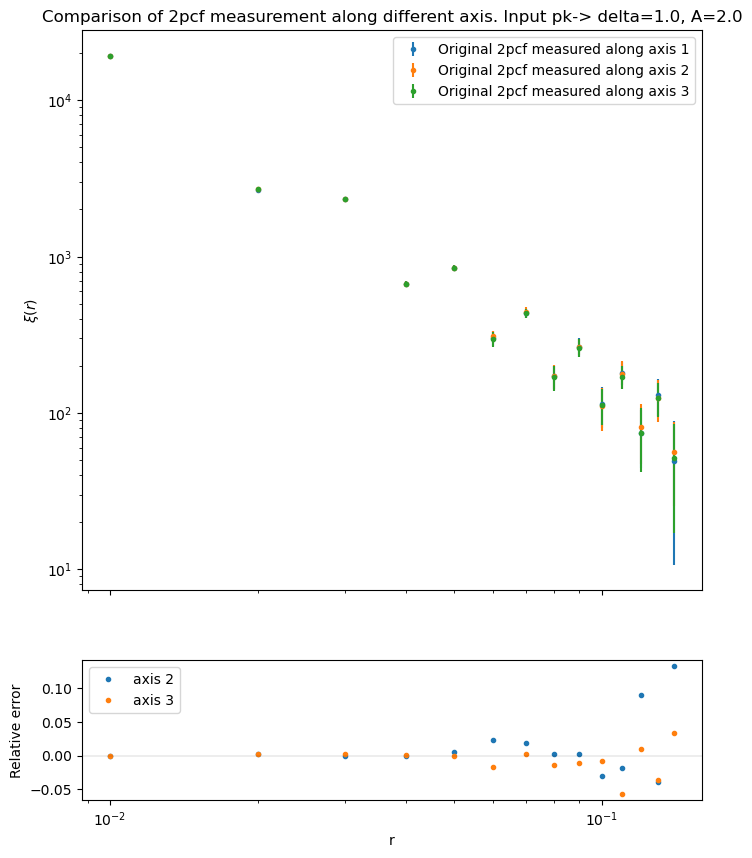

In [37]:
orig_2pcf_ax1_mean = np.array([19279.1938135, 2679.93719294, 2335.80384323, 668.85114595, 844.43692579, 301.22157641, 432.40590861, 171.14859056, 264.63297642, 113.50400364, 181.13429212, 74.04422619, 129.67366362, 49.52180394])
orig_2pcf_ax1_var = np.array([428.39626566, 725.58170636, 915.4622832, 878.75794928, 903.40281124, 1043.18487885, 766.51528968, 855.51809068, 1300.90867916, 1085.9183732, 967.82119767, 884.30434357, 1185.19080154, 1507.47472261])
orig_2pcf_ax2_mean = np.array([19269.66157178, 2685.75171368, 2335.56432906, 668.11452717, 848.46858621, 308.39451347, 440.14936245, 171.57466602, 265.34280212, 109.98751636, 177.88656276, 80.72063352, 124.58119831, 56.08969688])
orig_2pcf_ax2_var = np.array([532.79656172, 978.31643395, 806.94549886, 1093.72759107, 1012.65438389, 724.87383968, 1258.44634134, 937.72319939, 901.87813866, 1109.66073914, 1253.25650903, 1106.67485384, 1419.63460505, 945.54061919])
orig_2pcf_ax3_mean = np.array([19277.75845869, 2685.24632239, 2341.55302555, 669.83523894, 844.27510479, 296.23209748, 433.09581505, 168.62856368, 261.81914145, 112.61152136, 170.80998349, 74.71662152, 125.0038289, 51.20028383])
orig_2pcf_ax3_var = np.array([402.29344937, 763.37889787, 998.90724171, 1033.23854843, 1156.67800235, 1157.99326448, 940.944729, 959.53491871, 1244.79148508, 860.19196658, 815.23943777, 1094.71605773, 935.11150715, 1172.50555416])
x_intervals_mid = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10), height_ratios=[8,2], sharex=True)
ax1.errorbar(x_intervals_mid, orig_2pcf_ax1_mean, yerr=np.sqrt(orig_2pcf_ax1_var), fmt='.', label = "Original 2pcf measured along axis 1")
ax1.errorbar(x_intervals_mid, orig_2pcf_ax2_mean, yerr=np.sqrt(orig_2pcf_ax2_var), fmt='.', label = "Original 2pcf measured along axis 2")
ax1.errorbar(x_intervals_mid, orig_2pcf_ax3_mean, yerr=np.sqrt(orig_2pcf_ax3_var), fmt='.', label = "Original 2pcf measured along axis 3")
ax1.set_ylabel(r"$\xi(r)$")
ax1.legend()
ax2.plot(x_intervals_mid, (orig_2pcf_ax2_mean - orig_2pcf_ax1_mean)/orig_2pcf_ax1_mean, '.', label = "axis 2")
ax2.plot(x_intervals_mid, (orig_2pcf_ax3_mean - orig_2pcf_ax1_mean)/orig_2pcf_ax1_mean, '.', label = "axis 3")
ax2.set_ylabel("Relative error")
ax2.set_xlabel("r")
ax2.legend()
ax2.axhline(y=0, c='black', lw=0.1)
ax1.set_title("Comparison of 2pcf measurement along different axis. Input pk-> delta=1.0, A=2.0")
ax1.set_xscale('log')
ax1.set_yscale('log')

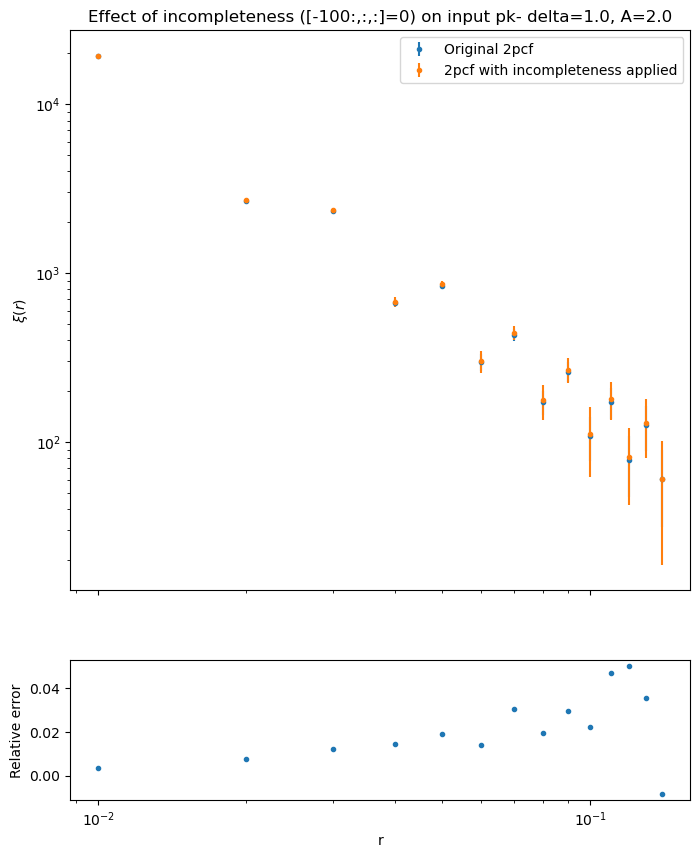

In [27]:
## delta = 1.0. Incompleteness effect with [-100:,:,:]=0
Original_2pcf_mean = np.array([19273.45473543, 2684.99650019, 2337.79985787, 667.38151298, 841.4734427, 297.61687412, 430.3013796, 173.08144101, 261.00422845, 108.99587396, 172.7567028, 77.91038024, 125.48915681, 60.59065747])
Original_2pcf_var = np.array([411.00271469, 785.62857873, 724.36774533, 1083.8256682, 1240.62220842, 1188.27820757, 1153.62372073, 812.40696788, 1214.23392149, 1013.98884898, 1230.12213193, 930.44802233, 1375.39567441, 854.28704998])
Incomp_2pcf_mean = np.array([19345.07986869, 2705.52579211, 2366.83838341, 677.20268611, 857.35565574, 301.75272597, 443.32946706, 176.44313492, 268.71216844, 111.40020859, 180.84255005, 81.79657711, 129.96722073, 60.09349518])
Incomp_2pcf_var = np.array([1592.93454713, 1694.5940792, 1508.85432411, 1941.92634389, 2001.84601046, 2047.96116, 1610.94845871, 1666.83640569, 1906.60820497, 2393.1155466, 2014.46101789, 1569.28036298, 2475.5389925, 1704.321318])
x_intervals_mid = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10), height_ratios=[8,2], sharex=True)
ax1.errorbar(x_intervals_mid, Original_2pcf_mean, yerr=np.sqrt(Original_2pcf_var), fmt='.', label = "Original 2pcf")
ax1.errorbar(x_intervals_mid, Incomp_2pcf_mean, yerr=np.sqrt(Incomp_2pcf_var), fmt='.', label="2pcf with incompleteness applied")
ax1.set_ylabel(r"$\xi(r)$")
ax1.legend()
ax2.plot(x_intervals_mid, (Incomp_2pcf_mean-Original_2pcf_mean)/Original_2pcf_mean, '.')
ax2.set_ylabel("Relative error")
ax2.set_xlabel("r")
ax1.set_title("Effect of incompleteness ([-100:,:,:]=0) on input pk- delta=1.0, A=2.0")
ax1.set_xscale('log')
ax1.set_yscale('log')

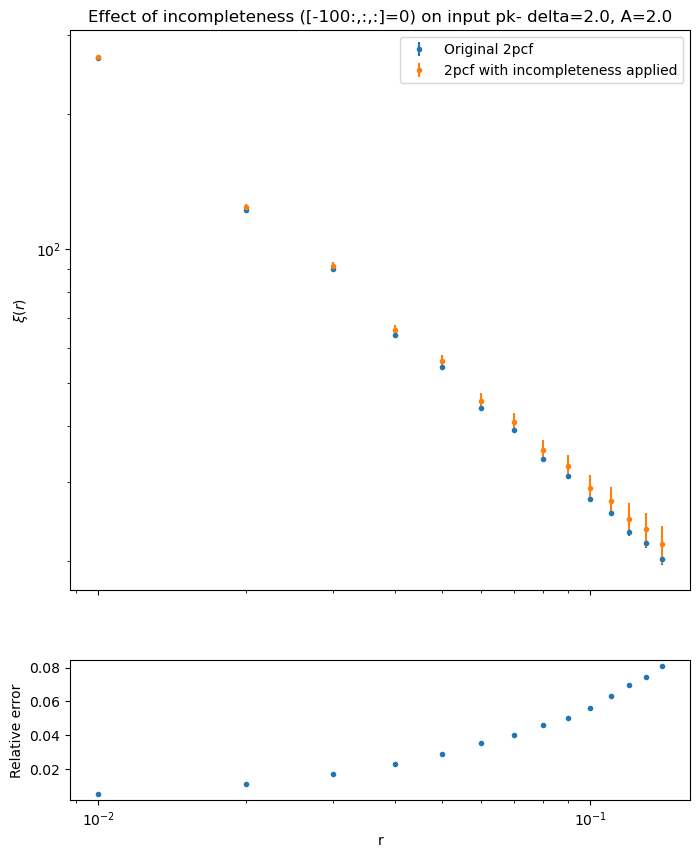

In [28]:
## delta = 2.0. Incompleteness effect with [-100:,:,:]=0
Original_2pcf_mean = np.array([266.99884989, 122.23216265, 89.80183418, 64.20819292, 54.35858305, 44.07915564, 39.34818848, 33.83911831, 31.02935889, 27.53679244, 25.65428761, 23.26603579, 21.92755252, 20.17128208])
Original_2pcf_var = np.array([0.00863462, 0.03489408, 0.05659858, 0.07822759, 0.09749772, 0.10687559, 0.11494324, 0.13144213, 0.15952492, 0.17735673, 0.21471388, 0.22256772, 0.26629812, 0.30805108])
Incomp_2pcf_mean = np.array([268.45579911, 123.62730589, 91.32747416, 65.69858444, 55.92972383, 45.63986817, 40.93558801, 35.3890497, 32.59523564, 29.08796204, 27.27230282, 24.88381626, 23.55580533, 21.79810801])
Incomp_2pcf_var = np.array([3.42428282, 3.57451865, 3.66328984, 3.66100644, 3.81267953, 3.78053989, 3.79436357, 3.81734832, 3.96703617, 3.99876943, 4.1923866, 4.32354916, 4.42341346, 4.4280265])
x_intervals_mid = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10), height_ratios=[8,2], sharex=True)
ax1.errorbar(x_intervals_mid, Original_2pcf_mean, yerr=np.sqrt(Original_2pcf_var), fmt='.', label = "Original 2pcf")
ax1.errorbar(x_intervals_mid, Incomp_2pcf_mean, yerr=np.sqrt(Incomp_2pcf_var), fmt='.', label="2pcf with incompleteness applied")
ax1.set_ylabel(r"$\xi(r)$")
ax1.legend()
ax2.plot(x_intervals_mid, (Incomp_2pcf_mean-Original_2pcf_mean)/Original_2pcf_mean, '.')
ax2.set_ylabel("Relative error")
ax2.set_xlabel("r")
ax1.set_title("Effect of incompleteness ([-100:,:,:]=0) on input pk- delta=2.0, A=2.0")
ax1.set_xscale('log')
ax1.set_yscale('log')

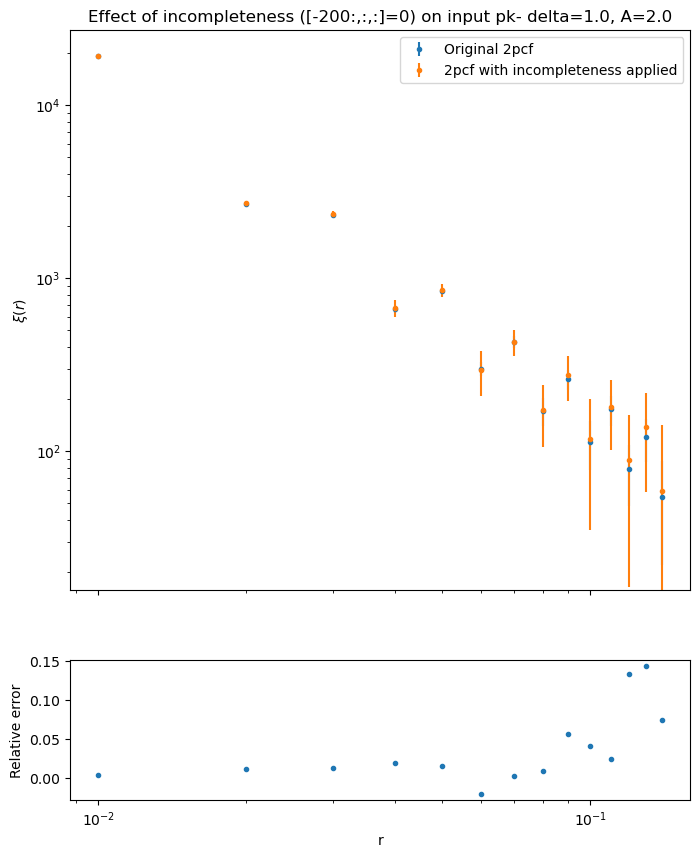

In [29]:
## delta = 1.0. Incompleteness effect with [-200:,:,:]=0
Original_2pcf_mean = np.array([19274.20433435, 2682.68025876, 2339.27579231, 665.40769705, 842.17892499, 299.44342319, 428.95373642, 172.23216043, 260.9909784, 113.58194635, 175.50159253, 78.70267919, 120.98187103, 54.78888263])
Original_2pcf_var = np.array([323.46111918, 888.9914467, 918.74371044, 967.07026304, 1173.75451103, 742.87136077, 1235.12720962, 1000.46916122, 1207.00443876, 1248.26613916, 1187.59729846, 919.47049536, 1143.97626171, 1066.88389518])
Incomp_2pcf_mean = np.array([19350.25100645, 2714.21472978, 2369.22866776, 678.22159338, 855.61614998, 293.51408246, 430.50164339, 173.83328866, 275.92008672, 118.3306752, 179.92578721, 89.25688365, 138.33444729, 58.90440051])
Incomp_2pcf_var = np.array([4383.99388231, 4478.39281863, 6330.68162208, 5884.53618204, 5271.05459035, 7268.47609276, 5553.95417888, 4576.97301867, 6656.16650009, 6939.1930032, 6095.56400491, 5295.69616188, 6387.6958218, 6864.51469843])
x_intervals_mid = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10), height_ratios=[8,2], sharex=True)
ax1.errorbar(x_intervals_mid, Original_2pcf_mean, yerr=np.sqrt(Original_2pcf_var), fmt='.', label = "Original 2pcf")
ax1.errorbar(x_intervals_mid, Incomp_2pcf_mean, yerr=np.sqrt(Incomp_2pcf_var), fmt='.', label="2pcf with incompleteness applied")
ax1.set_ylabel(r"$\xi(r)$")
ax1.legend()
ax2.plot(x_intervals_mid, (Incomp_2pcf_mean-Original_2pcf_mean)/Original_2pcf_mean, '.')
ax2.set_ylabel("Relative error")
ax2.set_xlabel("r")
ax1.set_title("Effect of incompleteness ([-200:,:,:]=0) on input pk- delta=1.0, A=2.0")
ax1.set_xscale('log')
ax1.set_yscale('log')

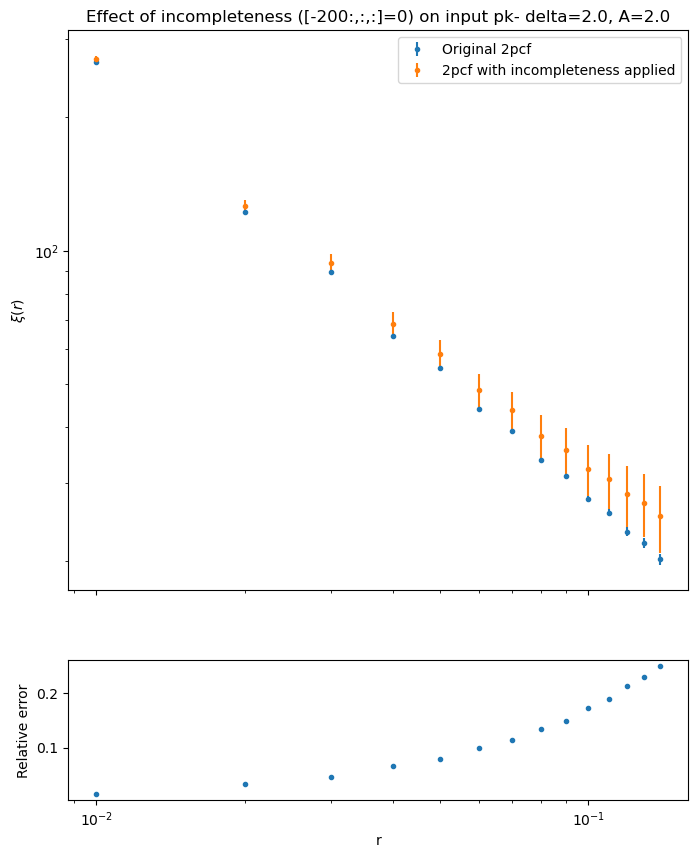

In [30]:
## delta = 2.0. Incompleteness effect with [-200:,:,:]=0
Original_2pcf_mean = np.array([267.0209347, 122.22502583, 89.78763103, 64.20187727, 54.36059978, 44.09072206, 39.34725352, 33.82262349, 31.02675226, 27.56316346, 25.70022781, 23.30386591, 21.95345105, 20.20806384])
Original_2pcf_var = np.array([0.00825212, 0.02338853, 0.0438182, 0.0661225, 0.07952982, 0.09766322, 0.11354204, 0.1263866, 0.13123448, 0.15696734, 0.20422049, 0.25754411, 0.28846998, 0.34031958])
Incomp_2pcf_mean = np.array([271.20213963, 126.31745674, 93.99206238, 68.46238399, 58.68977045, 48.46176918, 43.84770753, 38.32794832, 35.65331589, 32.31411206, 30.57800195, 28.27008229, 26.99946955, 25.22807026])
Incomp_2pcf_var = np.array([17.82475849, 17.35765256, 17.23195056, 17.34572201, 17.54983296, 17.99290262, 18.19558679, 18.09249583, 17.93556605, 18.24924531, 18.60540186, 19.32268356, 19.07536283, 18.83254389])
x_intervals_mid = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10), height_ratios=[8,2], sharex=True)
ax1.errorbar(x_intervals_mid, Original_2pcf_mean, yerr=np.sqrt(Original_2pcf_var), fmt='.', label = "Original 2pcf")
ax1.errorbar(x_intervals_mid, Incomp_2pcf_mean, yerr=np.sqrt(Incomp_2pcf_var), fmt='.', label="2pcf with incompleteness applied")
ax1.set_ylabel(r"$\xi(r)$")
ax1.legend()
ax2.plot(x_intervals_mid, (Incomp_2pcf_mean-Original_2pcf_mean)/Original_2pcf_mean, '.')
ax2.set_ylabel("Relative error")
ax2.set_xlabel("r")
ax1.set_title("Effect of incompleteness ([-200:,:,:]=0) on input pk- delta=2.0, A=2.0")
ax1.set_xscale('log')
ax1.set_yscale('log')

Text(0, 0.5, 'x')

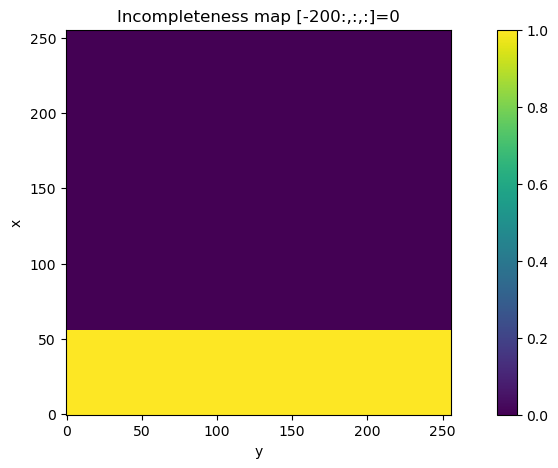

In [4]:
N_side = 256
dx = 0.01

box_GN = np.ones((256,256,256))
box_GN[-200:,:,:] = 0

fig, ax1 = plt.subplots(figsize=(12,5))
im = ax1.imshow(np.sum(box_GN, axis=2), vmin=0, vmax=1, origin='lower')
ax1.set_title("Incompleteness map [-200:,:,:]=0")
plt.colorbar(im)
ax1.set_xlabel('y')
ax1.set_ylabel('x')

### with error bar correlation function

In [51]:
N_side = 256
dx = 0.01
n_bar = 50
const_of_pk = 2.0
delta_of_pk = 1.0

A_arr100 = np.zeros(100)
alpha_arr100 = np.zeros(100)
for i in range(100):
    sample_clust = incomp_dist(N_side, dx)
    sample_clust.initialize_pois(n_bar)

    sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals)

    sample_clust.calc_2pcorrfunc_clust(1 * dx, 15 * dx)

    sample_clust.fit_2pcf_clust()

    A_arr100[i] = sample_clust._2pcf_fit_A
    alpha_arr100[i] = sample_clust._2pcf_fit_alpha

print("A mean= ", np.mean(A_arr100))
print("A var = ", np.var(A_arr100))
print("alpha mean = ", np.mean(alpha_arr100))
print("alpha var = ", np.var(alpha_arr100))

Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.


/tmp/ipykernel_1403980/161632270.py:139: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)


2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point co

#### Runs the GonzNuevoClust code for several deltas 100 times

In [52]:
N_side = 256
dx = 0.01
n_bar = 50
const_of_pk = 2.0
delta_of_pk_arr = [1.0, 1.5, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5, 2.6, 2.7, 2.8]

for delta_of_pk in delta_of_pk_arr:
    A_arr100 = np.zeros(100)
    alpha_arr100 = np.zeros(100)
    for i in range(100):
        sample_clust = incomp_dist(N_side, dx)
        sample_clust.initialize_pois(n_bar)

        sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals)

        sample_clust.calc_2pcorrfunc_clust(1 * dx, 15 * dx)

        sample_clust.fit_2pcf_clust()

        A_arr100[i] = sample_clust._2pcf_fit_A
        alpha_arr100[i] = sample_clust._2pcf_fit_alpha

    print("delta= ", delta_of_pk)
    print("A mean= ", np.mean(A_arr100))
    print("A var = ", np.var(A_arr100))
    print("alpha mean = ", np.mean(alpha_arr100))
    print("alpha var = ", np.var(alpha_arr100))

Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.


/tmp/ipykernel_1403980/161632270.py:139: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)


2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point co

### With Error bar incompleteness effect

In [4]:
import sys, os

sys._jupyter_stdout = sys.stdout

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys._jupyter_stdout

In [14]:
N_side = 256
dx = 0.01
n_bar = 50
const_of_pk = 2.0
delta_of_pk_arr = [1.0, 1.5, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5, 2.6, 2.7, 2.8]

for delta_of_pk in delta_of_pk_arr:
    A_arr100 = np.zeros(100)
    alpha_arr100 = np.zeros(100)
    for i in range(100):
        blockPrint()
        sample_clust = incomp_dist(N_side, dx)
        sample_clust.initialize_pois(n_bar)

        sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals)

        sample_clust.calc_2pcorrfunc_clust(1 * dx, 15 * dx)

        sample_clust.fit_2pcf_clust()

        exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

        sample_clust.initiate_incomp_eff()
        sample_clust.incomp_map[-100:,:,:] = 0
        sample_clust.apply_incomp_map()
        sample_clust.calc_2pcorrfunc_incomp()
        sample_clust.fit_2pcf_clust_incomp()

        A_arr100[i] = sample_clust._2pcf_fit_A_incomp
        alpha_arr100[i] = sample_clust._2pcf_fit_alpha_incomp

    enablePrint()
    print("A mean= ", np.mean(A_arr100))
    print("A var = ", np.var(A_arr100))
    print("alpha mean = ", np.mean(alpha_arr100))
    print("alpha var = ", np.var(alpha_arr100))


/tmp/ipykernel_1766005/161632270.py:139: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
/tmp/ipykernel_1766005/1679162206.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc_incomp[i] = np.sum((self.incomp_box_delx_clust[:self.N_side-temp_x,:,:]) * (self.incomp_box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
/tmp/ipykernel_1766005/1679162206.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc_incomp[i] = self._2pcorrfunc_incomp[i]/(np.sum(self.incomp_map[:self.N_side-temp_x,:,:] * self.incomp_map[temp_x:,:,:])/ (self.N_side**3))


In [ ]:
N_side = 256
dx = 0.01
n_bar = 50
const_of_pk = 2.0
delta_of_pk_arr = [1.0, 1.5, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5, 2.6, 2.7, 2.8]

for delta_of_pk in delta_of_pk_arr:
    A_arr100 = np.zeros(100)
    alpha_arr100 = np.zeros(100)
    for i in range(100):
        sample_clust = incomp_dist(N_side, dx)
        sample_clust.initialize_pois(n_bar)

        sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals)

        sample_clust.calc_2pcorrfunc_clust(1 * dx, 15 * dx)

        sample_clust.fit_2pcf_clust()

        A_arr100[i] = sample_clust._2pcf_fit_A
        alpha_arr100[i] = sample_clust._2pcf_fit_alpha

    print("delta= ", delta_of_pk)
    print("A mean= ", np.mean(A_arr100))
    print("A var = ", np.var(A_arr100))
    print("alpha mean = ", np.mean(alpha_arr100))
    print("alpha var = ", np.var(alpha_arr100))

### With errorbar incompletness effect of particular power spectrum

In [8]:
N_side = 256
dx = 0.01
n_bar = 50
const_of_pk = 2.0
delta_of_pk = 1.0

orig_2pcf = np.zeros((100,14))
incomp_2pcf = np.zeros((100,14))
for i in range(100):
    blockPrint()
    sample_clust = incomp_dist(N_side, dx)
    sample_clust.initialize_pois(n_bar)

    sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals)

    sample_clust.calc_2pcorrfunc_clust(1 * dx, 15 * dx)

    sample_clust.fit_2pcf_clust()

    # exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

    sample_clust.initiate_incomp_eff()
    sample_clust.incomp_map[-200:,:,:] = 0
    sample_clust.apply_incomp_map()
    sample_clust.calc_2pcorrfunc_incomp()

    orig_2pcf[i] = sample_clust._2pcorrfunc
    incomp_2pcf[i] = sample_clust._2pcorrfunc_incomp

# sample_clust.fit_2pcf_clust_incomp()
sys.stdout = open("tempoutput.txt",'w')
print("orig_2pcf mean =", np.mean(orig_2pcf, axis=0))
print("orig_2pcf var = ", np.var(orig_2pcf, axis=0))
print("incomp_2pcf mean = ", np.mean(incomp_2pcf, axis=0))
print("incomp_2pcf var = ", np.var(incomp_2pcf, axis=0))

/tmp/ipykernel_1871197/3652077428.py:139: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
/tmp/ipykernel_1871197/1679162206.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc_incomp[i] = np.sum((self.incomp_box_delx_clust[:self.N_side-temp_x,:,:]) * (self.incomp_box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
/tmp/ipykernel_1871197/1679162206.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc_incomp[i] = self._2pcorrfunc_incomp[i]/(np.sum(self.incomp_map[:self.N_side-temp_x,:,:] * self.incomp_map[temp_x:,:,:])/ (self.N_side**3))


In [5]:
N_side = 256
dx = 0.01
n_bar = 50
const_of_pk = 2.0
delta_of_pk = 2.0

orig_2pcf = np.zeros((100,14))
incomp_2pcf = np.zeros((100,14))
for i in range(100):
    blockPrint()
    sample_clust = incomp_dist(N_side, dx)
    sample_clust.initialize_pois(n_bar)

    sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals)

    sample_clust.calc_2pcorrfunc_clust(1 * dx, 15 * dx)

    sample_clust.fit_2pcf_clust()

    # exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

    sample_clust.initiate_incomp_eff()
    sample_clust.incomp_map[-200:,:,:] = 0
    sample_clust.apply_incomp_map()
    sample_clust.calc_2pcorrfunc_incomp()

    orig_2pcf[i] = sample_clust._2pcorrfunc
    incomp_2pcf[i] = sample_clust._2pcorrfunc_incomp

# sample_clust.fit_2pcf_clust_incomp()
sys.stdout = open("tempoutput2.txt",'w')
print("orig_2pcf mean =", np.mean(orig_2pcf, axis=0))
print("orig_2pcf var = ", np.var(orig_2pcf, axis=0))
print("incomp_2pcf mean = ", np.mean(incomp_2pcf, axis=0))
print("incomp_2pcf var = ", np.var(incomp_2pcf, axis=0))

/tmp/ipykernel_1875167/3652077428.py:139: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
/tmp/ipykernel_1875167/1679162206.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc_incomp[i] = np.sum((self.incomp_box_delx_clust[:self.N_side-temp_x,:,:]) * (self.incomp_box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
/tmp/ipykernel_1875167/1679162206.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc_incomp[i] = self._2pcorrfunc_incomp[i]/(np.sum(self.incomp_map[:self.N_side-temp_x,:,:] * self.incomp_map[temp_x:,:,:])/ (self.N_side**3))


## GonzNuevo code in detail

In [62]:
plaw_2pcf_to_pspec(np.power(15.2, 2.0), 2.0)

(409.50773771321036, 1.0)

In [3]:
N_side = 256
dx = 0.01
n_bar = 50
const_of_pk = 409.5
delta_of_pk = 1.0

sample_clust = clust_dist(N_side, dx)
sample_clust.initialize_pois(n_bar)

sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals) 

sample_clust.calc_2pcorrfunc_clust(1.0 * dx, 15 * dx)

sample_clust.fit_2pcf_clust()

exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.


/tmp/ipykernel_2003582/1412635400.py:143: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)


2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law


Text(0.5, 1.0, 'measurement of 2pcf from 1 realisation of the clustering code $P(k) = 409.5k^{-1.0}$')

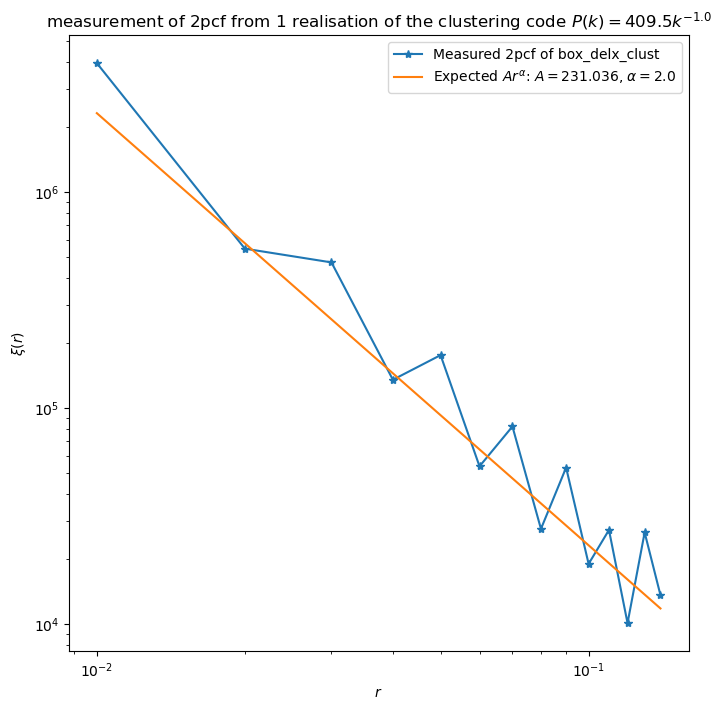

In [4]:
plt.figure(figsize=(8,8))
plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcorrfunc, '*-', label="Measured 2pcf of box_delx_clust")
# plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcf_fit_A * np.power(sample_clust.x_intervals_mid, -sample_clust._2pcf_fit_alpha), \
#                 label=r"Plaw fit: $A = {}$, $\alpha = {}$".format(np.round(sample_clust._2pcf_fit_A,3), np.round(sample_clust._2pcf_fit_alpha,3)))
plt.plot(sample_clust.x_intervals_mid, exp_A * np.power(sample_clust.x_intervals_mid, -exp_alpha), \
            label=r"Expected $Ar^{{\alpha}}$: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend()
plt.title(r"measurement of 2pcf from 1 realisation of the clustering code $P(k) = {}k^{{-{}}}$".format(sample_clust.const_of_pk, sample_clust.delta_of_pk))


(<Figure size 1200x500 with 2 Axes>,
 (<Axes: title={'center': 'power spectrum of poisson lattice'}, xlabel='$k$', ylabel='$P(K)$'>,
  <Axes: title={'center': 'power spectrum of clustered lattice'}, xlabel='$k$', ylabel='$P(K)$'>))

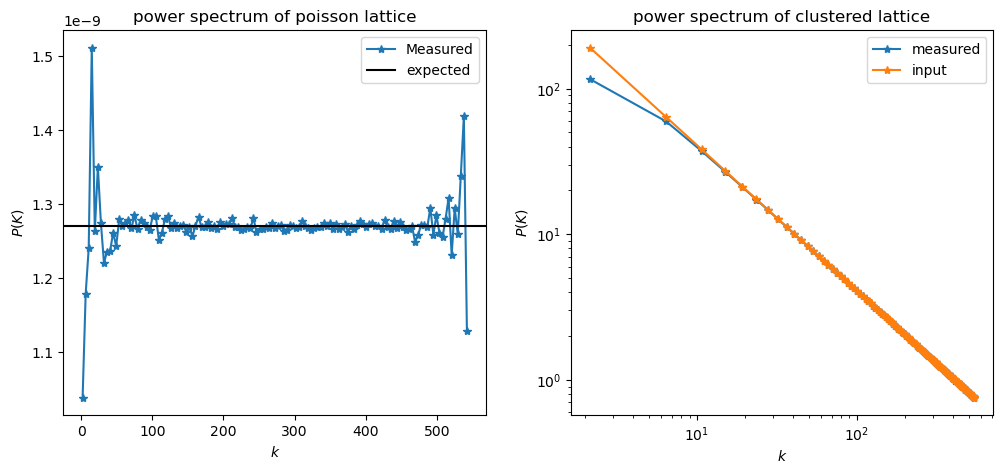

In [5]:
sample_clust.show_powerspecs()

Text(0.5, 1.0, '2d Powerspectrum of the clustered distribution')

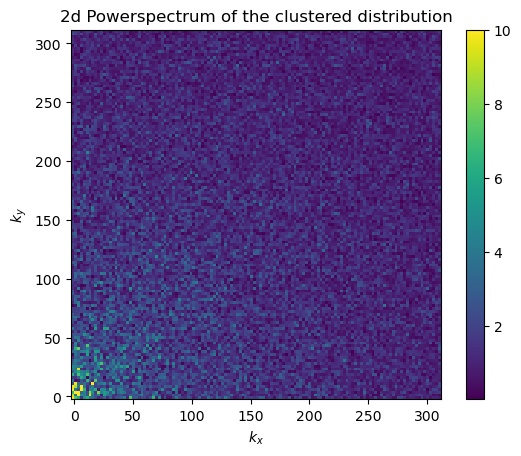

In [12]:
temp_mid = int(len(sample_clust.temp_k_vals)/2)
temp_diff = np.diff(sample_clust.temp_k_vals)[0]
k_edges = np.insert(sample_clust.temp_k_vals - (temp_diff/2), temp_mid + 1, sample_clust.temp_k_vals[temp_mid]+temp_diff) 
plt.pcolormesh(k_edges[:temp_mid], k_edges[:temp_mid], np.absolute(sample_clust.box_delk_clust[:temp_mid,:temp_mid,0]), vmax=10)
plt.gca().set_aspect('equal')
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.title("2d Powerspectrum of the clustered distribution")

Text(0.5, 1.0, '2d Powerspectrum of the poisson distribution')

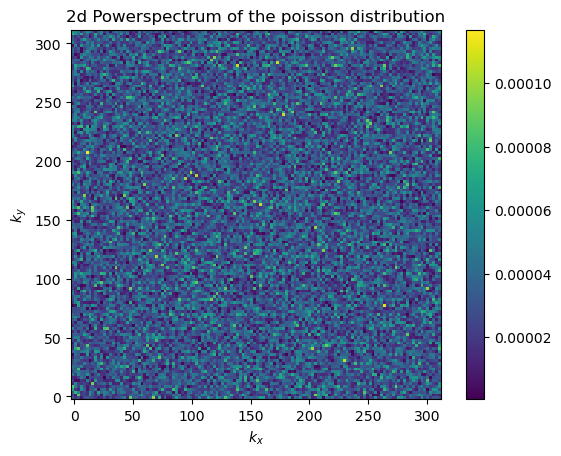

In [13]:
temp_mid = int(len(sample_clust.temp_k_vals)/2)
temp_diff = np.diff(sample_clust.temp_k_vals)[0]
k_edges = np.insert(sample_clust.temp_k_vals - (temp_diff/2), temp_mid + 1, sample_clust.temp_k_vals[temp_mid]+temp_diff) 
plt.pcolormesh(k_edges[:temp_mid], k_edges[:temp_mid], np.absolute(sample_clust.box_delk[:temp_mid,:temp_mid,0]))
plt.gca().set_aspect('equal')
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.title("2d Powerspectrum of the poisson distribution")

Text(0.5, 1.0, 'Full 2d powerspectrum')

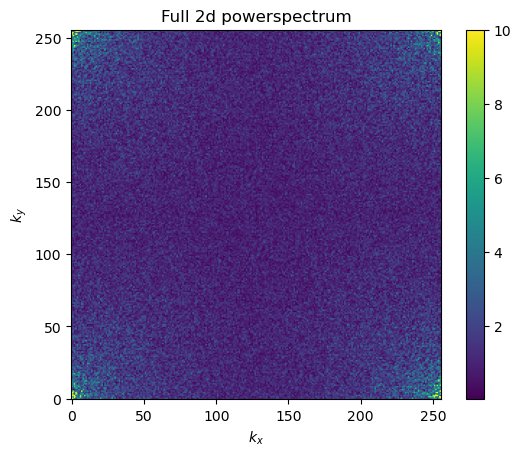

In [14]:
plt.imshow(np.absolute(sample_clust.box_delk_clust[:,:,0]), vmax=10, origin='lower')
plt.colorbar()
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.title("Full 2d powerspectrum")

/home/vibin/anaconda3/envs/dp2/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/vibin/anaconda3/envs/dp2/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


Text(0.6, 0.76, 'mean of clustered = 49.998')

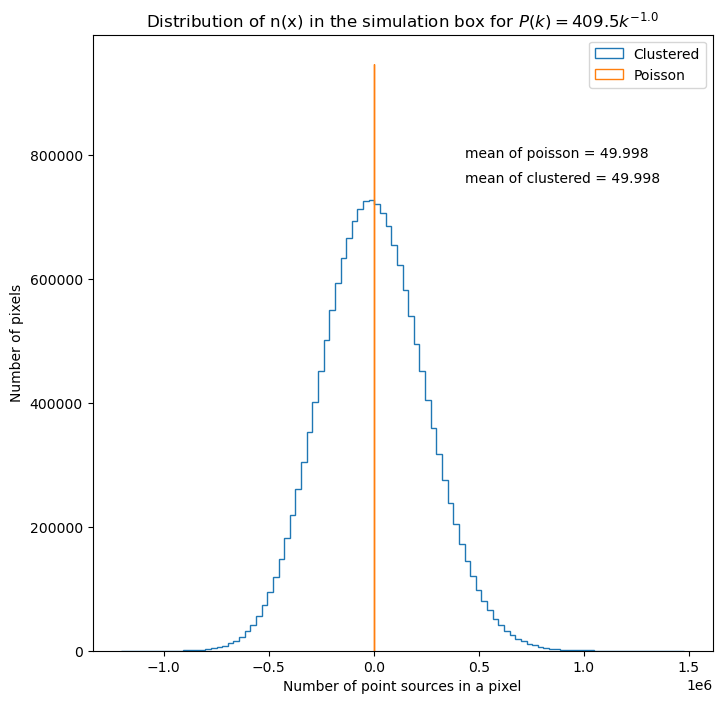

In [6]:
plt.figure(figsize=(8,8))
plt.hist(sample_clust.box_GN.flatten(), bins=100, label="Clustered", histtype='step')
plt.hist(sample_clust.box_p.flatten(), bins=100, label="Poisson", histtype='step');
plt.xlabel("Number of point sources in a pixel")
plt.ylabel("Number of pixels")
plt.legend()
plt.title(r"Distribution of n(x) in the simulation box for $P(k) = {}k^{{-{}}}$".format(sample_clust.const_of_pk, sample_clust.delta_of_pk))
plt.text(0.6, 0.8, "mean of poisson = "+str(np.round(np.mean(sample_clust.box_p.flatten()),3)), transform=plt.gca().transAxes)
plt.text(0.6, 0.76, "mean of clustered = "+str(np.round(np.absolute(np.mean(sample_clust.box_GN.flatten())),3)), transform=plt.gca().transAxes)

Text(0.6, 0.76, 'mean of clustered = 0.0')

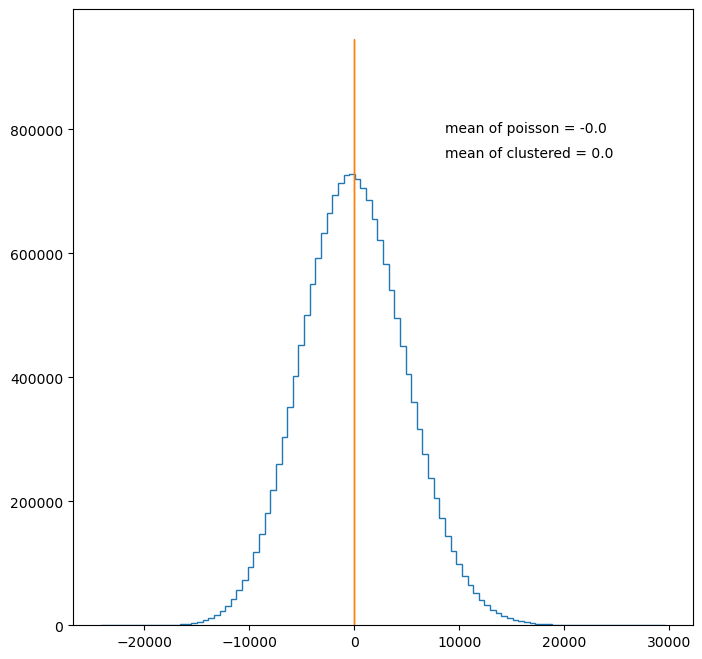

In [7]:
plt.figure(figsize=(8,8))
plt.hist(sample_clust.box_delx_clust.flatten(), bins=100, label="Clustered", histtype='step')
plt.hist(sample_clust.box_delx.flatten(), bins=100, label="Poisson", histtype='step');
plt.text(0.6, 0.8, "mean of poisson = "+str(np.round(np.mean(sample_clust.box_delx.flatten()),3)), transform=plt.gca().transAxes)
plt.text(0.6, 0.76, "mean of clustered = "+str(np.round(np.absolute(np.mean(sample_clust.box_delx_clust.flatten())),3)), transform=plt.gca().transAxes)

In [145]:
for i, (k1, k2) in enumerate(zip(sample_clust.k_intervals[:-1], sample_clust.k_intervals[1:])):
    if i ==2: break;
    # print(i, k1, k2)
    temp_ind = np.where((sample_clust.modk_grid >= k1) & (sample_clust.modk_grid < k2))
    # print(i, temp_ind)
    sample_clust.box_delk_clust[temp_ind] = sample_clust.box_delk[temp_ind] * (np.sqrt(sample_clust.powerspec_clust[i] + sample_clust.powerspec_pois[i])) / np.sqrt(sample_clust.powerspec_pois[i])
    # print(sample_clust.modk_grid[temp_ind])
    print((np.sqrt(sample_clust.powerspec_clust[i] + sample_clust.powerspec_pois[i])) / np.sqrt(sample_clust.powerspec_pois[i]))

326952.6537498278
218436.1345333041


In [136]:
sample_clust.box_delk_clust[np.where(sample_clust.modk_grid == 0)]

array([15.15644726+0.j])

In [14]:
N_side = 256
dx = 0.01
n_bar = 50
const_of_pk = 409.5
delta_of_pk = 1.0

sample_clust = clust_dist(N_side, dx)
sample_clust.initialize_pois(n_bar)

sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals) 

sample_clust.calc_2pcorrfunc_clust(1.0 * dx, 50 * dx)

sample_clust.fit_2pcf_clust()

exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.


/tmp/ipykernel_2013144/4266683574.py:143: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)


2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law


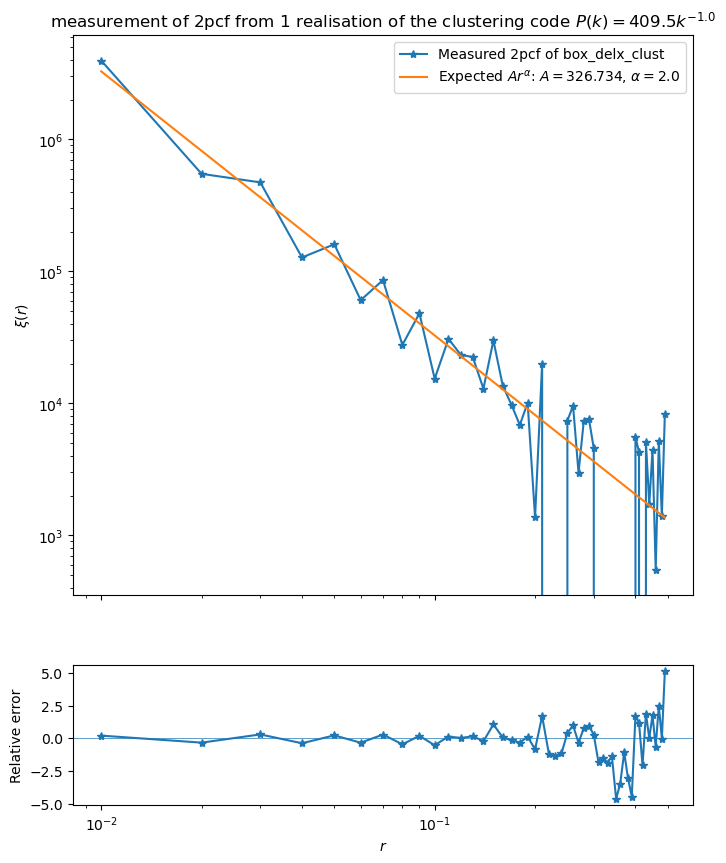

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10), height_ratios=(8,2), sharex=True)
ax1.plot(sample_clust.x_intervals_mid, sample_clust._2pcorrfunc, '*-', label="Measured 2pcf of box_delx_clust")
# plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcf_fit_A * np.power(sample_clust.x_intervals_mid, -sample_clust._2pcf_fit_alpha), \
#                 label=r"Plaw fit: $A = {}$, $\alpha = {}$".format(np.round(sample_clust._2pcf_fit_A,3), np.round(sample_clust._2pcf_fit_alpha,3)))
temp_exp_corr = exp_A * np.power(sample_clust.x_intervals_mid, -exp_alpha)
ax1.plot(sample_clust.x_intervals_mid, temp_exp_corr, \
            label=r"Expected $Ar^{{\alpha}}$: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlabel(r'$r$')
ax1.set_ylabel(r'$\xi(r)$')
ax1.legend()
ax1.set_title(r"measurement of 2pcf from 1 realisation of the clustering code $P(k) = {}k^{{-{}}}$".format(sample_clust.const_of_pk, sample_clust.delta_of_pk))
ax2.set_ylabel(r"Relative error")
ax2.plot(sample_clust.x_intervals_mid, (sample_clust._2pcorrfunc-temp_exp_corr)/temp_exp_corr, '*-', label = "Measured, k-smoothed")
ax2.axhline(0, lw=0.5)

(<Figure size 1200x500 with 2 Axes>,
 (<Axes: title={'center': 'power spectrum of poisson lattice'}, xlabel='$k$', ylabel='$P(K)$'>,
  <Axes: title={'center': 'power spectrum of clustered lattice'}, xlabel='$k$', ylabel='$P(K)$'>))

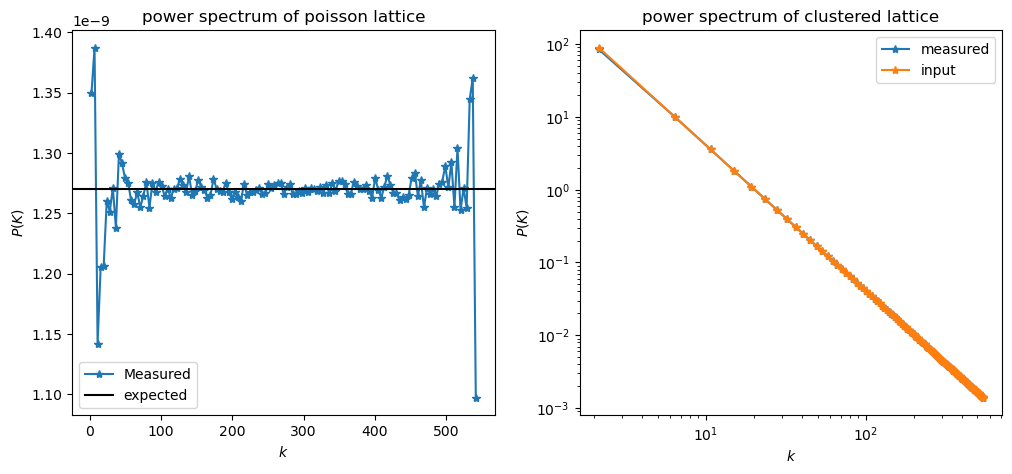

In [155]:
sample_clust.show_powerspecs()

Text(0.6, 0.76, 'mean of clustered = 50.0')

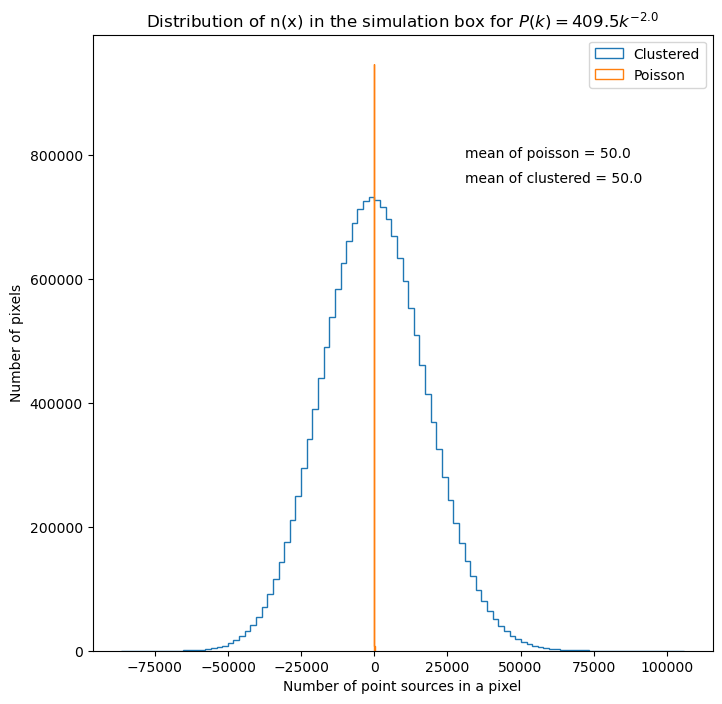

In [10]:
plt.figure(figsize=(8,8))
plt.hist(sample_clust.box_GN.flatten(), bins=100, label="Clustered", histtype='step')
plt.hist(sample_clust.box_p.flatten(), bins=100, label="Poisson", histtype='step');
plt.xlabel("Number of point sources in a pixel")
plt.ylabel("Number of pixels")
plt.legend()
plt.title(r"Distribution of n(x) in the simulation box for $P(k) = {}k^{{-{}}}$".format(sample_clust.const_of_pk, sample_clust.delta_of_pk))
plt.text(0.6, 0.8, "mean of poisson = "+str(np.round(np.mean(sample_clust.box_p.flatten()),3)), transform=plt.gca().transAxes)
plt.text(0.6, 0.76, "mean of clustered = "+str(np.round(np.absolute(np.mean(sample_clust.box_GN.flatten())),3)), transform=plt.gca().transAxes)

In [4]:
N_side = 256
dx = 0.01
n_bar = 50
const_of_pk = 40
delta_of_pk = 2.0

exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

sample_clust = clust_dist(N_side, dx)
sample_clust.initialize_pois(n_bar)
sample_clust.const_of_pk = const_of_pk
sample_clust.delta_of_pk = delta_of_pk

temp_pk = np.zeros_like(sample_clust.k_intervals_mid)

temp_k_eff = 3/4 * (np.power(sample_clust.k_intervals[1:], 4) - np.power(sample_clust.k_intervals[:-1], 4))/(np.power(sample_clust.k_intervals[1:], 3) - np.power(sample_clust.k_intervals[:-1], 3))
temp_pk = const_of_pk * np.power(temp_k_eff, -delta_of_pk)
sample_clust.make_clust_dist(temp_pk, sample_clust.k_intervals)
# sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals) 
sample_clust.calc_2pcorrfunc_clust(1.0 * dx, 50 * dx)
temp_pspec1 = np.copy(sample_clust.powerspec_clust)
temp_corr1 = np.copy(sample_clust._2pcorrfunc)
temp_box_gn1 = np.copy(sample_clust.box_GN)
temp_box_delx1 = np.copy(sample_clust.box_delx_clust)

for i, (k1, k2) in enumerate(zip(sample_clust.k_intervals[:-1], sample_clust.k_intervals[1:])):
    temp_pk[i] = 3 * const_of_pk/(3 - delta_of_pk) * (np.power(k2, 3 - delta_of_pk) - np.power(k1, 3 - delta_of_pk))/(np.power(k2, 3) - np.power(k1, 3))
sample_clust.make_clust_dist(temp_pk, sample_clust.k_intervals)
# sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals) 
sample_clust.calc_2pcorrfunc_clust(1.0 * dx, 50 * dx)
temp_pspec2 = np.copy(sample_clust.powerspec_clust)
temp_corr2 = np.copy(sample_clust._2pcorrfunc)
temp_box_gn2 = np.copy(sample_clust.box_GN)
temp_box_delx2 = np.copy(sample_clust.box_delx_clust)

temp_pk = const_of_pk * np.power(sample_clust.k_intervals_mid, -delta_of_pk )
sample_clust.make_clust_dist(temp_pk, sample_clust.k_intervals) 
# sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals)
sample_clust.calc_2pcorrfunc_clust(1.0 * dx, 50 * dx)
temp_pspec3 = np.copy(sample_clust.powerspec_clust)
temp_corr3 = np.copy(sample_clust._2pcorrfunc)
temp_box_gn3 = np.copy(sample_clust.box_GN)
temp_box_delx3 = np.copy(sample_clust.box_delx_clust)


Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.


/tmp/ipykernel_2013144/2262131143.py:143: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)


2 point correlation function calculated.
Made the clustered distribution.
2 point correlation function calculated.
Made the clustered distribution.
2 point correlation function calculated.


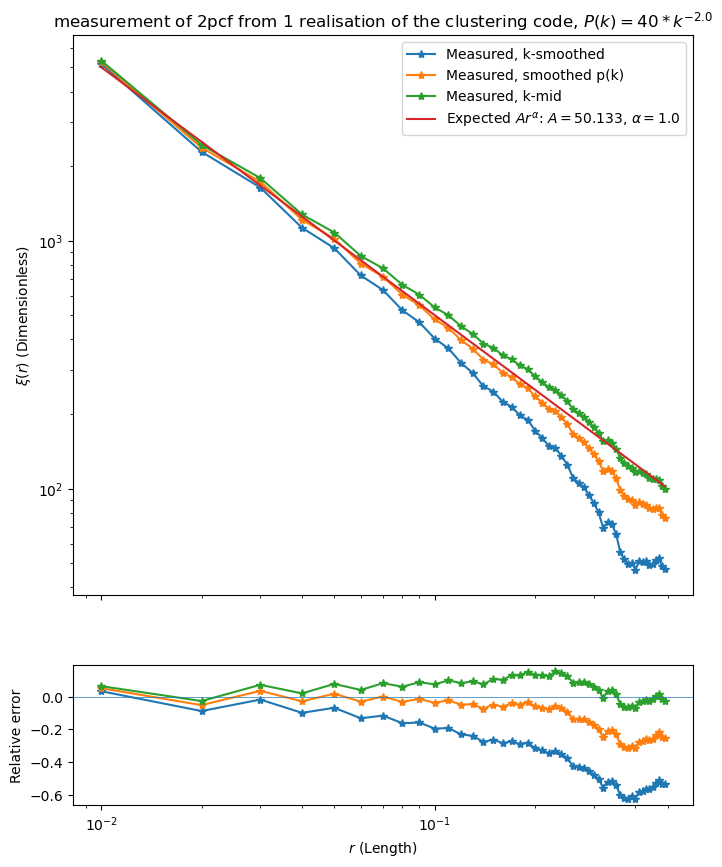

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10), height_ratios=(8,2), sharex=True)
ax1.plot(sample_clust.x_intervals_mid, temp_corr1, '*-', label="Measured, k-smoothed")
ax1.plot(sample_clust.x_intervals_mid, temp_corr2, '*-', label="Measured, smoothed p(k)")
ax1.plot(sample_clust.x_intervals_mid, temp_corr3, '*-', label="Measured, k-mid")
# plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcf_fit_A * np.power(sample_clust.x_intervals_mid, -sample_clust._2pcf_fit_alpha), \
#                 label=r"Plaw fit: $A = {}$, $\alpha = {}$".format(np.round(sample_clust._2pcf_fit_A,3), np.round(sample_clust._2pcf_fit_alpha,3)))
temp_exp_corr = exp_A * np.power(sample_clust.x_intervals_mid, -exp_alpha)
ax1.plot(sample_clust.x_intervals_mid, temp_exp_corr, \
            label=r"Expected $Ar^{{\alpha}}$: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlabel(r'$r$ (Length)')
ax1.set_ylabel(r'$\xi(r)$ (Dimensionless)')
ax1.legend()
ax1.set_title(r"measurement of 2pcf from 1 realisation of the clustering code, $P(k) = {}*k^{{-{}}}$".format(const_of_pk, delta_of_pk))
ax2.set_ylabel(r"Relative error")
ax2.plot(sample_clust.x_intervals_mid, (temp_corr1-temp_exp_corr)/temp_exp_corr, '*-', label = "Measured, k-smoothed")
ax2.plot(sample_clust.x_intervals_mid, (temp_corr2-temp_exp_corr)/temp_exp_corr, '*-', label = "Measured, smoothed p(k)")
ax2.plot(sample_clust.x_intervals_mid, (temp_corr3-temp_exp_corr)/temp_exp_corr, '*-', label = "Measured, k-mid")
ax2.axhline(0, lw=0.5)

Text(0, 0.5, '$P(k)$ (Length$^{{3}}$)')

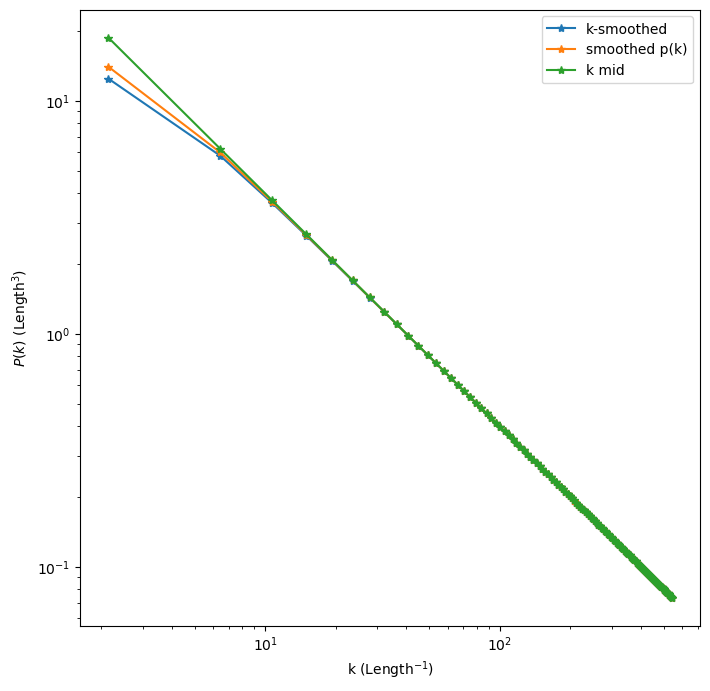

In [6]:
plt.figure(figsize=(8,8))
plt.plot(sample_clust.k_intervals_mid, temp_pspec1, '*-', label="k-smoothed")
plt.plot(sample_clust.k_intervals_mid, temp_pspec2, '*-', label="smoothed p(k)")
plt.plot(sample_clust.k_intervals_mid, temp_pspec3, '*-', label="k mid")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'k (Length$^{{-1}}$)')
plt.ylabel(r'$P(k)$ (Length$^{{3}}$)')

/home/vibin/anaconda3/envs/dp2/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/vibin/anaconda3/envs/dp2/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


Text(0.6, 0.76, 'mean of clustered = 50.002')

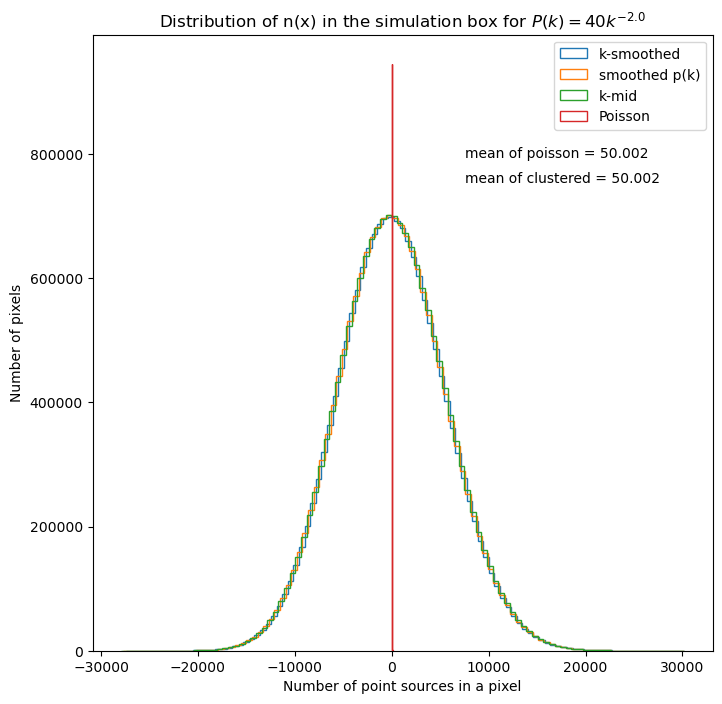

In [6]:
plt.figure(figsize=(8,8))
plt.hist(temp_box_gn1.flatten(), bins=100, label="k-smoothed", histtype='step')
plt.hist(temp_box_gn2.flatten(), bins=100, label="smoothed p(k)", histtype='step')
plt.hist(temp_box_gn3.flatten(), bins=100, label="k-mid", histtype='step')
plt.hist(sample_clust.box_p.flatten(), bins=100, label="Poisson", histtype='step');
plt.xlabel("Number of point sources in a pixel")
plt.ylabel("Number of pixels")
plt.legend()
plt.title(r"Distribution of n(x) in the simulation box for $P(k) = {}k^{{-{}}}$".format(sample_clust.const_of_pk, sample_clust.delta_of_pk))
plt.text(0.6, 0.8, "mean of poisson = "+str(np.round(np.mean(sample_clust.box_p.flatten()),3)), transform=plt.gca().transAxes)
plt.text(0.6, 0.76, "mean of clustered = "+str(np.round(np.absolute(np.mean(sample_clust.box_GN.flatten())),3)), transform=plt.gca().transAxes)

Text(0.6, 0.76, 'mean of clustered = 0.0')

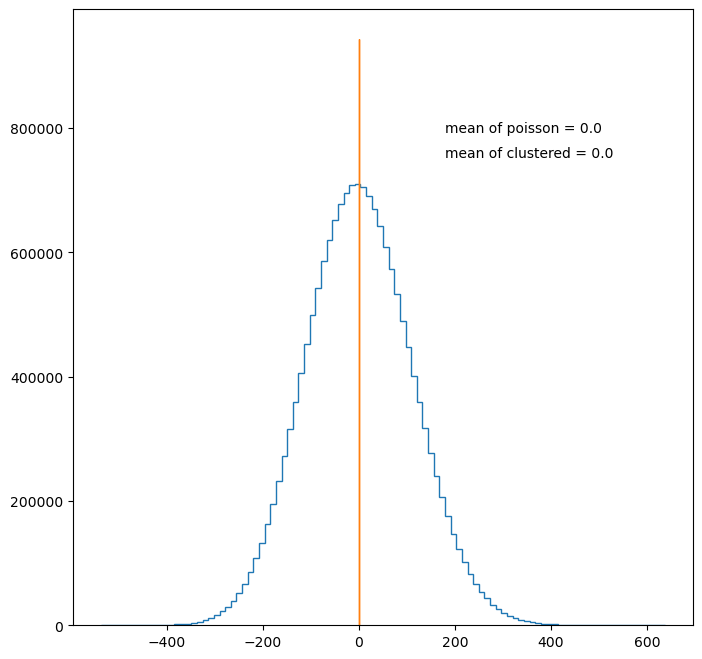

In [94]:
plt.figure(figsize=(8,8))
plt.hist(sample_clust.box_delx_clust.flatten(), bins=100, label="Clustered", histtype='step')
plt.hist(sample_clust.box_delx.flatten(), bins=100, label="Poisson", histtype='step');
plt.text(0.6, 0.8, "mean of poisson = "+str(np.round(np.mean(sample_clust.box_delx.flatten()),3)), transform=plt.gca().transAxes)
plt.text(0.6, 0.76, "mean of clustered = "+str(np.round(np.absolute(np.mean(sample_clust.box_delx_clust.flatten())),3)), transform=plt.gca().transAxes)